In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [4]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [5]:
z_dim = 10
run_id = 46
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [6]:
experiment_name = "semi_sup_gaussian_mah_k8"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=8,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [7]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [9]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior 

Epoch: 0/67, Nll_loss : 191.4849090576172 KLD:1.1727218627929688  Supervised loss:0.0
Epoch: 0/68, Nll_loss : 206.76437377929688 KLD:1.3233795166015625  Supervised loss:0.0
Epoch: 0/69, Nll_loss : 209.0908660888672 KLD:1.2705203294754028  Supervised loss:0.0
Epoch: 0/70, Nll_loss : 200.67950439453125 KLD:1.3186397552490234  Supervised loss:0.0
Epoch: 0/71, Nll_loss : 202.90870666503906 KLD:1.3583446741104126  Supervised loss:0.0
Epoch: 0/72, Nll_loss : 203.34783935546875 KLD:1.4371528625488281  Supervised loss:0.0
Epoch: 0/73, Nll_loss : 202.44497680664062 KLD:1.2665038108825684  Supervised loss:0.0
Epoch: 0/74, Nll_loss : 210.5441131591797 KLD:1.2716621160507202  Supervised loss:0.0
Epoch: 0/75, Nll_loss : 193.65640258789062 KLD:1.2491388320922852  Supervised loss:0.0
Epoch: 0/76, Nll_loss : 201.6982421875 KLD:1.4167228937149048  Supervised loss:0.0
Epoch: 0/77, Nll_loss : 199.73291015625 KLD:1.1057754755020142  Supervised loss:0.0
Epoch: 0/78, Nll_loss : 204.14617919921875 KLD:1.2256

Epoch: 0/162, Nll_loss : 182.9658203125 KLD:2.2214653491973877  Supervised loss:0.0
Epoch: 0/163, Nll_loss : 183.96658325195312 KLD:2.2292943000793457  Supervised loss:0.0
Epoch: 0/164, Nll_loss : 182.11575317382812 KLD:2.429056167602539  Supervised loss:0.0
Epoch: 0/165, Nll_loss : 186.6619415283203 KLD:2.5582752227783203  Supervised loss:0.0
Epoch: 0/166, Nll_loss : 181.1005859375 KLD:2.562227964401245  Supervised loss:0.0
Epoch: 0/167, Nll_loss : 180.0013427734375 KLD:2.63073468208313  Supervised loss:0.0
Epoch: 0/168, Nll_loss : 176.4146728515625 KLD:2.6510367393493652  Supervised loss:0.0
Epoch: 0/169, Nll_loss : 178.61341857910156 KLD:2.9963340759277344  Supervised loss:0.0
Epoch: 0/170, Nll_loss : 176.2899627685547 KLD:3.2425408363342285  Supervised loss:0.0
Epoch: 0/171, Nll_loss : 180.93775939941406 KLD:2.822437047958374  Supervised loss:0.0
Epoch: 0/172, Nll_loss : 175.09283447265625 KLD:2.6990342140197754  Supervised loss:0.0
Epoch: 0/173, Nll_loss : 178.02377319335938 KLD:2

Epoch: 0/258, Nll_loss : 150.0369873046875 KLD:4.6118645668029785  Supervised loss:0.0
Epoch: 0/259, Nll_loss : 159.41751098632812 KLD:4.400754928588867  Supervised loss:0.0
Epoch: 0/260, Nll_loss : 151.235595703125 KLD:4.4874067306518555  Supervised loss:0.0
Epoch: 0/261, Nll_loss : 155.6063232421875 KLD:4.37921142578125  Supervised loss:0.0
Epoch: 0/262, Nll_loss : 156.94642639160156 KLD:4.007627487182617  Supervised loss:0.0
Epoch: 0/263, Nll_loss : 170.2618408203125 KLD:3.6179866790771484  Supervised loss:0.0
Epoch: 0/264, Nll_loss : 153.54324340820312 KLD:3.813258647918701  Supervised loss:0.0
Epoch: 0/265, Nll_loss : 158.05352783203125 KLD:3.6304173469543457  Supervised loss:0.0
Epoch: 0/266, Nll_loss : 157.43508911132812 KLD:3.7073607444763184  Supervised loss:0.0
Epoch: 0/267, Nll_loss : 164.36032104492188 KLD:3.669456958770752  Supervised loss:0.0
Epoch: 0/268, Nll_loss : 171.1104736328125 KLD:4.010727405548096  Supervised loss:0.0
Epoch: 0/269, Nll_loss : 167.7754669189453 KL

Epoch: 0/354, Nll_loss : 155.13226318359375 KLD:4.934913158416748  Supervised loss:0.0
Epoch: 0/355, Nll_loss : 160.36676025390625 KLD:5.028209686279297  Supervised loss:0.0
Epoch: 0/356, Nll_loss : 156.12643432617188 KLD:4.846175670623779  Supervised loss:0.0
Epoch: 0/357, Nll_loss : 154.1673583984375 KLD:4.821311950683594  Supervised loss:0.0
Epoch: 0/358, Nll_loss : 146.18231201171875 KLD:4.944742202758789  Supervised loss:0.0
Epoch: 0/359, Nll_loss : 157.423583984375 KLD:5.012751579284668  Supervised loss:0.0
Epoch: 0/360, Nll_loss : 148.97671508789062 KLD:5.1129961013793945  Supervised loss:0.0
Epoch: 0/361, Nll_loss : 153.11672973632812 KLD:5.049343585968018  Supervised loss:0.0
Epoch: 0/362, Nll_loss : 151.39761352539062 KLD:5.013733863830566  Supervised loss:0.0
Epoch: 0/363, Nll_loss : 146.9503173828125 KLD:4.867856025695801  Supervised loss:0.0
Epoch: 0/364, Nll_loss : 151.50546264648438 KLD:4.775405406951904  Supervised loss:0.0
Epoch: 0/365, Nll_loss : 147.92617797851562 KL

Epoch: 0/449, Nll_loss : 149.166259765625 KLD:5.324902534484863  Supervised loss:0.0
Epoch: 0/450, Nll_loss : 153.71615600585938 KLD:4.87688684463501  Supervised loss:0.0
Epoch: 0/451, Nll_loss : 152.6250762939453 KLD:5.094741344451904  Supervised loss:0.0
Epoch: 0/452, Nll_loss : 143.53289794921875 KLD:5.238627910614014  Supervised loss:0.0
Epoch: 0/453, Nll_loss : 155.1596221923828 KLD:5.431750297546387  Supervised loss:0.0
Epoch: 0/454, Nll_loss : 142.6131134033203 KLD:5.130687236785889  Supervised loss:0.0
Epoch: 0/455, Nll_loss : 143.42420959472656 KLD:5.161755561828613  Supervised loss:0.0
Epoch: 0/456, Nll_loss : 152.99526977539062 KLD:5.174407005310059  Supervised loss:0.0
Epoch: 0/457, Nll_loss : 137.27276611328125 KLD:4.947193622589111  Supervised loss:0.0
Epoch: 0/458, Nll_loss : 144.529296875 KLD:4.904521942138672  Supervised loss:0.0
Epoch: 0/459, Nll_loss : 148.960693359375 KLD:5.147932052612305  Supervised loss:0.0
Epoch: 0/460, Nll_loss : 144.80043029785156 KLD:5.037689

Epoch: 0/544, Nll_loss : 147.19198608398438 KLD:5.627206325531006  Supervised loss:0.0
Epoch: 0/545, Nll_loss : 151.01365661621094 KLD:5.7138495445251465  Supervised loss:0.0
Epoch: 0/546, Nll_loss : 143.61270141601562 KLD:5.42616081237793  Supervised loss:0.0
Epoch: 0/547, Nll_loss : 144.9837646484375 KLD:5.450987339019775  Supervised loss:0.0
Epoch: 0/548, Nll_loss : 135.9366455078125 KLD:5.4060282707214355  Supervised loss:0.0
Epoch: 0/549, Nll_loss : 142.1149139404297 KLD:5.309388160705566  Supervised loss:0.0
Epoch: 0/550, Nll_loss : 142.83363342285156 KLD:5.355818748474121  Supervised loss:0.0
Epoch: 0/551, Nll_loss : 143.45486450195312 KLD:5.415690898895264  Supervised loss:0.0
Epoch: 0/552, Nll_loss : 134.1513671875 KLD:5.114629745483398  Supervised loss:0.0
Epoch: 0/553, Nll_loss : 143.60565185546875 KLD:5.385381698608398  Supervised loss:0.0
Epoch: 0/554, Nll_loss : 142.74069213867188 KLD:5.344381332397461  Supervised loss:0.0
Epoch: 0/555, Nll_loss : 145.8121337890625 KLD:5.

Epoch: 0/640, Nll_loss : 137.85665893554688 KLD:5.629981994628906  Supervised loss:0.0
Epoch: 0/641, Nll_loss : 137.169189453125 KLD:5.567990779876709  Supervised loss:0.0
Epoch: 0/642, Nll_loss : 154.6531219482422 KLD:5.7237396240234375  Supervised loss:0.0
Epoch: 0/643, Nll_loss : 146.68023681640625 KLD:5.584786415100098  Supervised loss:0.0
Epoch: 0/644, Nll_loss : 140.41493225097656 KLD:5.455102920532227  Supervised loss:0.0
Epoch: 0/645, Nll_loss : 135.74420166015625 KLD:5.4170002937316895  Supervised loss:0.0
Epoch: 0/646, Nll_loss : 147.11471557617188 KLD:5.229619026184082  Supervised loss:0.0
Epoch: 0/647, Nll_loss : 141.99559020996094 KLD:5.324723243713379  Supervised loss:0.0
Epoch: 0/648, Nll_loss : 141.613525390625 KLD:5.7271928787231445  Supervised loss:0.0
Epoch: 0/649, Nll_loss : 142.5414276123047 KLD:5.612812519073486  Supervised loss:0.0
Epoch: 0/650, Nll_loss : 135.46917724609375 KLD:5.719103813171387  Supervised loss:0.0
Epoch: 0/651, Nll_loss : 147.08828735351562 KL

Epoch: 0/736, Nll_loss : 132.13510131835938 KLD:5.129860877990723  Supervised loss:0.0
Epoch: 0/737, Nll_loss : 137.71315002441406 KLD:5.568964004516602  Supervised loss:0.0
Epoch: 0/738, Nll_loss : 145.45086669921875 KLD:5.485004425048828  Supervised loss:0.0
Epoch: 0/739, Nll_loss : 128.96653747558594 KLD:5.526279449462891  Supervised loss:0.0
Epoch: 0/740, Nll_loss : 139.07528686523438 KLD:5.6991071701049805  Supervised loss:0.0
Epoch: 0/741, Nll_loss : 139.88851928710938 KLD:5.6527910232543945  Supervised loss:0.0
Epoch: 0/742, Nll_loss : 134.95675659179688 KLD:5.7946271896362305  Supervised loss:0.0
Epoch: 0/743, Nll_loss : 148.6477508544922 KLD:6.4876813888549805  Supervised loss:0.0
Epoch: 0/744, Nll_loss : 134.2527618408203 KLD:6.5484466552734375  Supervised loss:0.0
Epoch: 0/745, Nll_loss : 134.2894287109375 KLD:6.624141693115234  Supervised loss:0.0
Epoch: 0/746, Nll_loss : 135.56167602539062 KLD:6.6365556716918945  Supervised loss:0.0
Epoch: 0/747, Nll_loss : 135.84896850585

Epoch: 0/833, Nll_loss : 129.12210083007812 KLD:6.180274963378906  Supervised loss:0.0
Epoch: 0/834, Nll_loss : 138.28118896484375 KLD:6.419622421264648  Supervised loss:0.0
Epoch: 0/835, Nll_loss : 134.12631225585938 KLD:6.569230556488037  Supervised loss:0.0
Epoch: 0/836, Nll_loss : 137.55935668945312 KLD:6.600371837615967  Supervised loss:0.0
Epoch: 0/837, Nll_loss : 135.92784118652344 KLD:6.160778045654297  Supervised loss:0.0
Epoch: 0/838, Nll_loss : 130.75828552246094 KLD:6.067988872528076  Supervised loss:0.0
Epoch: 0/839, Nll_loss : 145.008544921875 KLD:5.636401176452637  Supervised loss:0.0
Epoch: 0/840, Nll_loss : 140.33544921875 KLD:5.678071022033691  Supervised loss:0.0
Epoch: 0/841, Nll_loss : 144.07492065429688 KLD:5.629551410675049  Supervised loss:0.0
Epoch: 0/842, Nll_loss : 132.36489868164062 KLD:5.541435718536377  Supervised loss:0.0
Epoch: 0/843, Nll_loss : 124.32231903076172 KLD:5.696288585662842  Supervised loss:0.0
Epoch: 0/844, Nll_loss : 136.46044921875 KLD:5.9

Epoch: 0/929, Nll_loss : 136.33349609375 KLD:6.3003692626953125  Supervised loss:0.0
Epoch: 0/930, Nll_loss : 128.69381713867188 KLD:6.701848983764648  Supervised loss:0.0
Epoch: 0/931, Nll_loss : 133.6497802734375 KLD:6.265809059143066  Supervised loss:0.0
Epoch: 0/932, Nll_loss : 140.14219665527344 KLD:6.020702362060547  Supervised loss:0.0
Epoch: 0/933, Nll_loss : 130.6005859375 KLD:5.988278388977051  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 131.050048828125 KLD:5.8956217765808105  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 131.050048828125
Completed 0 epochs
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/analysis/
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/analysis/
Running evaluation after epoch:1 and step:935

# Load the trained model

In [10]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameter

# Read the latent vectors for train data

In [11]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=46 z_min=-4.251307499999999 z_max=4.5513554
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [12]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

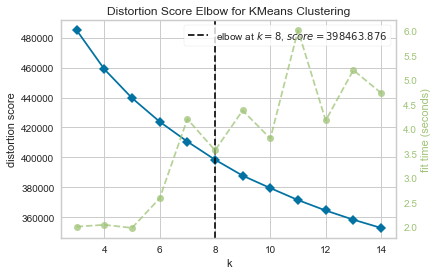

In [13]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [14]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [15]:
num_clusters

10


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_EL

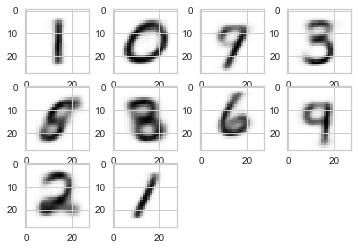

In [16]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [18]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [1, 0, -1, 3,
                                               -1, -1, 6, 9,
                                               2, 1
                                              ]
    manual_annotation_json["manual_confidence"] = [1, 1, 0, 0.8,
                                                  0, 0, 0.7, 0.7,
                                                  0.7, 1]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [19]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [20]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [21]:
cluster_group_dict

{None: <clearn.analysis.ClusterGroup at 0x7f89a83b4c50>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7f89a83a6890>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7f89a83a6c50>}

In [22]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


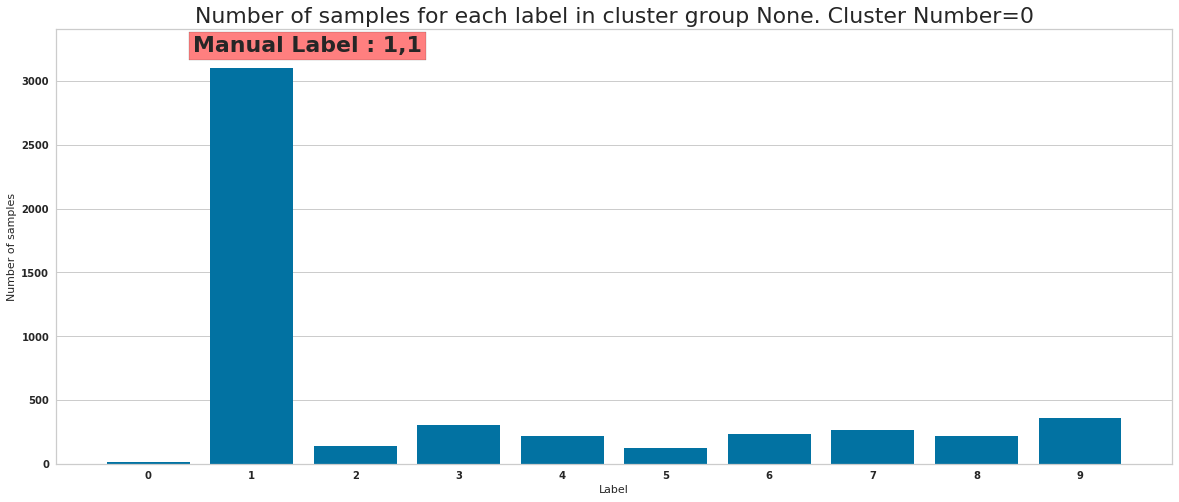

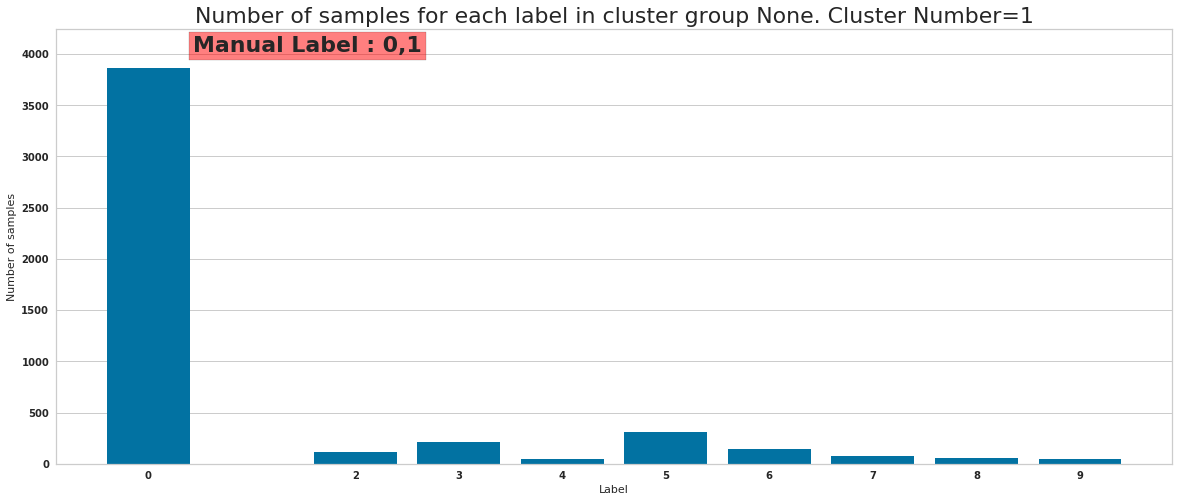

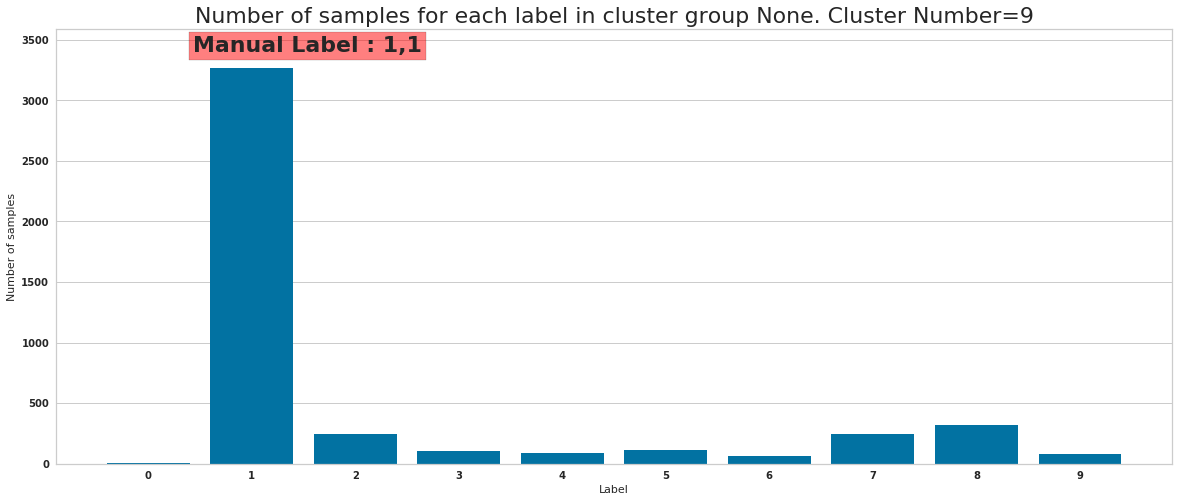

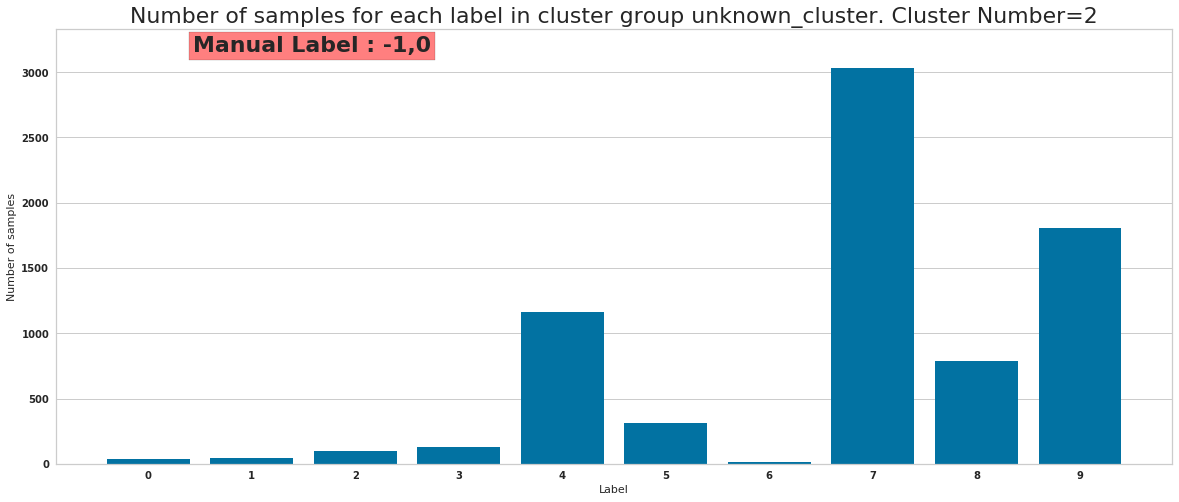

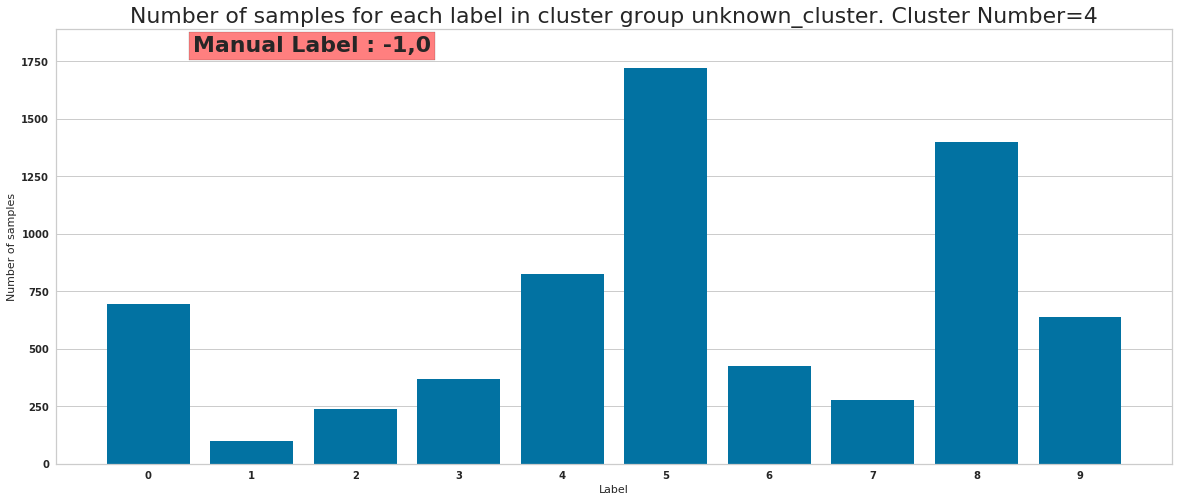

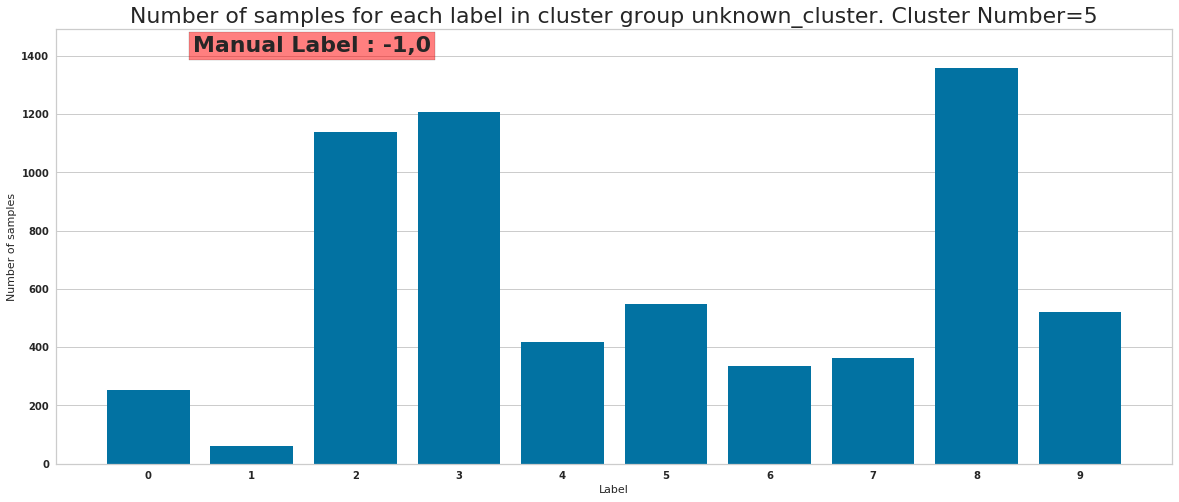

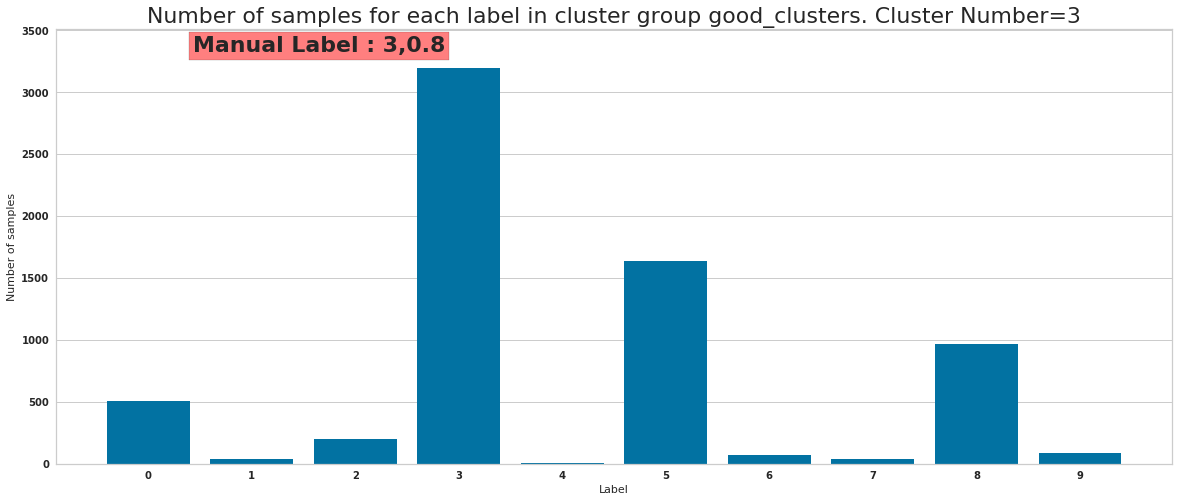

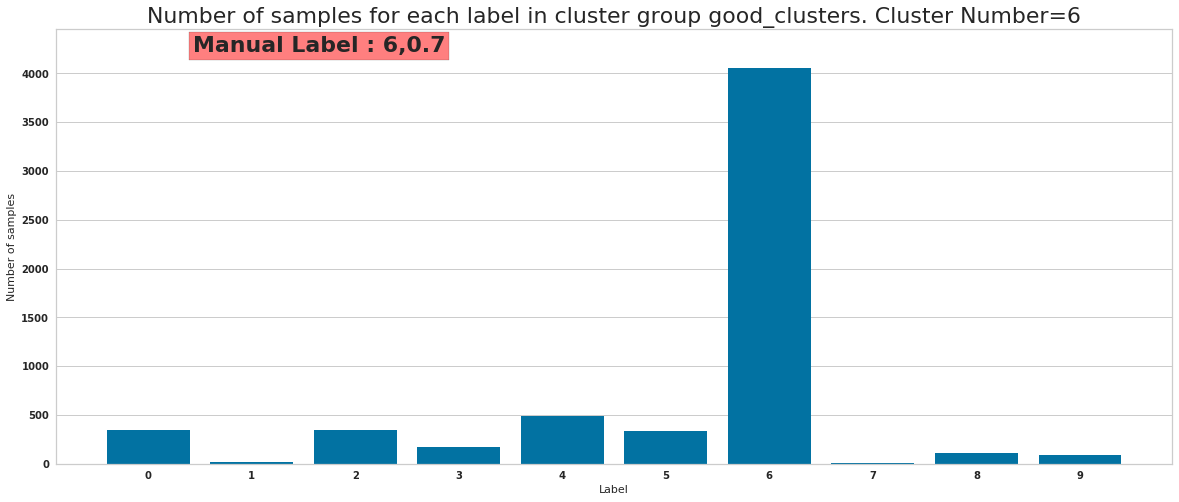

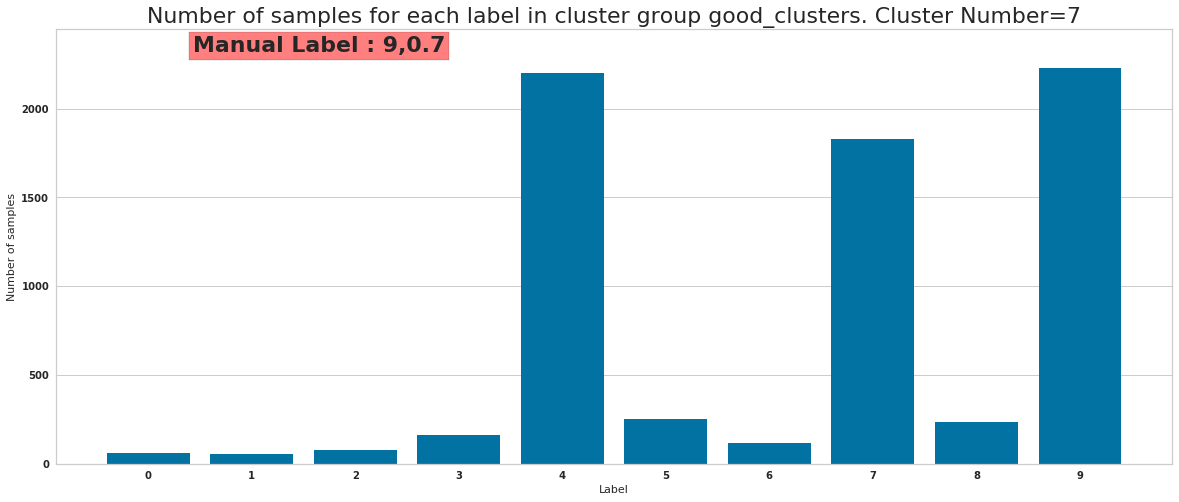

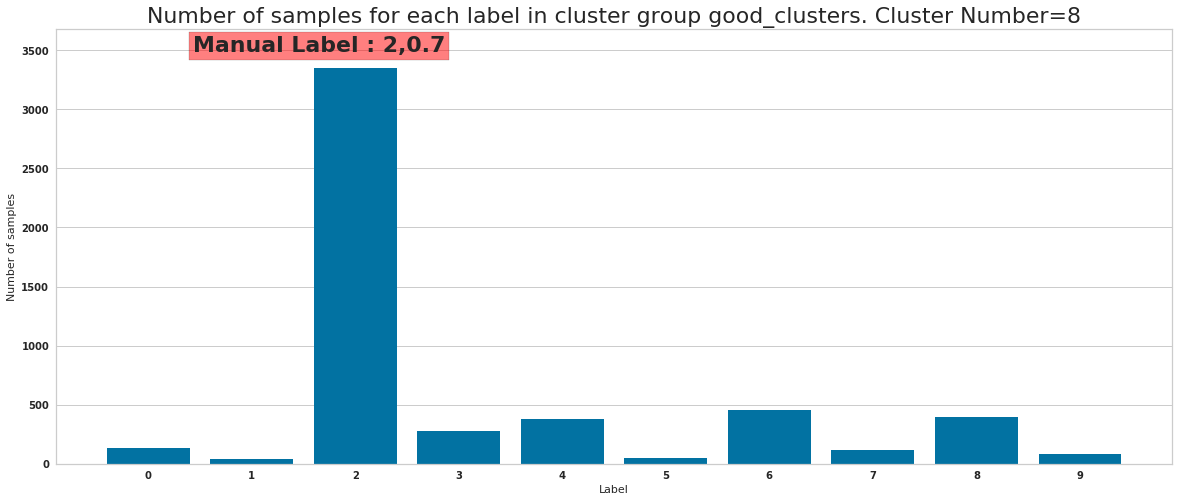

In [23]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [24]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(4966, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4853, 10)
(7404, 10)
(6744, 10)
(6686, 10)
(6205, 10)
(5958, 10)
(7212, 10)
(5274, 10)
(4538, 10)


2

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_E

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


5
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_E

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


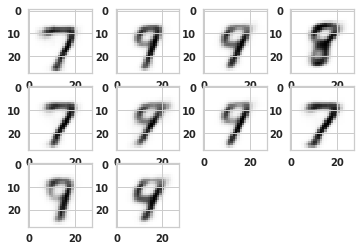

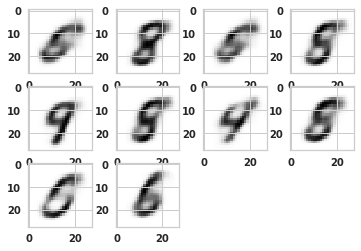

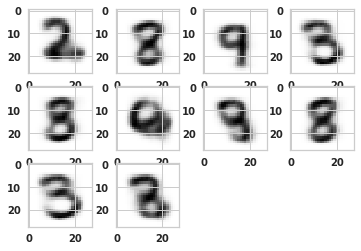

In [25]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [26]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [7, 9, 9, 8,
                                        7, -1, -1, 7,
                                         -1, -1]
level_2_cluster_dict["manual_confidences"] = [0.7, 0.7, 0.7, 0.7,
                                              0.8, 0, 0, 0.7,
                                              0, 0]
level2_manual_annotations[2] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, 0, -1,-1,
                                        6, -1, -1, -1,
                                        -1, -1]
level_2_cluster_dict["manual_confidences"] = [0, 0.8, 0, 0,
                                              0.6, 0, 0, 0,
                                              0, 0
                                             ]

level2_manual_annotations[4] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [2, 8, 9, -1,
                                        -1, -1, -1, 8,
                                        -1, -1]
level_2_cluster_dict["manual_confidences"] = [0.7, 0.7, 0.7, 0,
                                              0, 0, 0, 0.7,
                                              0, 0
                                             ]
level2_manual_annotations[5] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [27]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

2
4
5


In [28]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

10
0 (685,)
1 (835,)
2 (714,)
3 (661,)
4 (732,)
7 (705,)
Skipping distance computation for unknown cluster
10
Skipping distance computation for unknown cluster
1 (691,)
4 (658,)
10
0 (605,)
1 (664,)
2 (553,)
7 (647,)
Skipping distance computation for unknown cluster


In [29]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [30]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [31]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [32]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [33]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

Manual Label 1
(4966, 77) (4966, 33)
Num correct=3099
Cluster 0 Manual Label 1 Percentage correct 62.40434957712445
********************************
Manual Label 0
(4853, 77) (4853, 33)
Num correct=3859
Cluster 1 Manual Label 0 Percentage correct 79.51782402637544
********************************
unknown
<class 'dict'>
['good_clusters', 'unknown_cluster']
********7*******
Manual_label 7
********9*******
Manual_label 9
********9*******
Manual_label 9
********8*******
Manual_label 8
********7*******
Manual_label 7
********7*******
Manual_label 7
********-1*******
Annotating individual samples (698,)
********-1*******
Annotating individual samples (812,)
********-1*******
Annotating individual samples (704,)
********-1*******
Annotating individual samples (858,)
********************************
Manual Label 3
(6795, 77) (6744, 33)
Num correct=3243
Cluster 3 Manual Label 3 Percentage correct 47.72626931567329
********************************
unknown
<class 'dict'>
['unknown_cluster', 'good

# Save the dataframe with manual annotations

In [34]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([4966., 4853., 7404., 6744., 6686., 6205., 5958., 7212., 5274.,
        4538.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

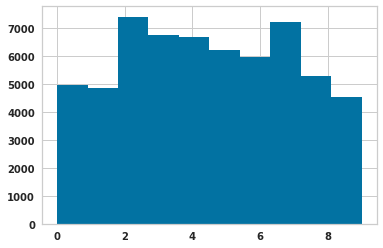

In [35]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [36]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


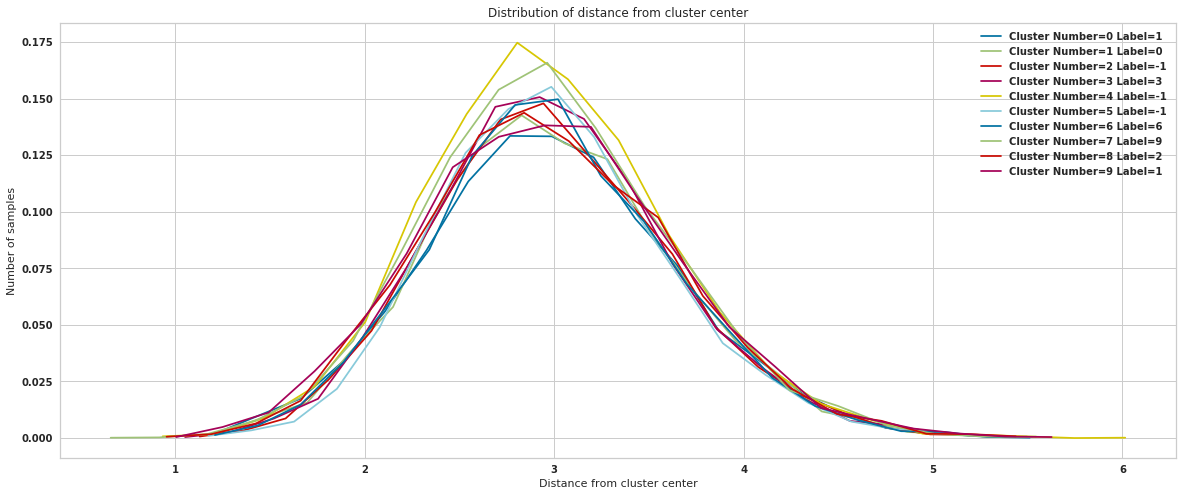

In [37]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

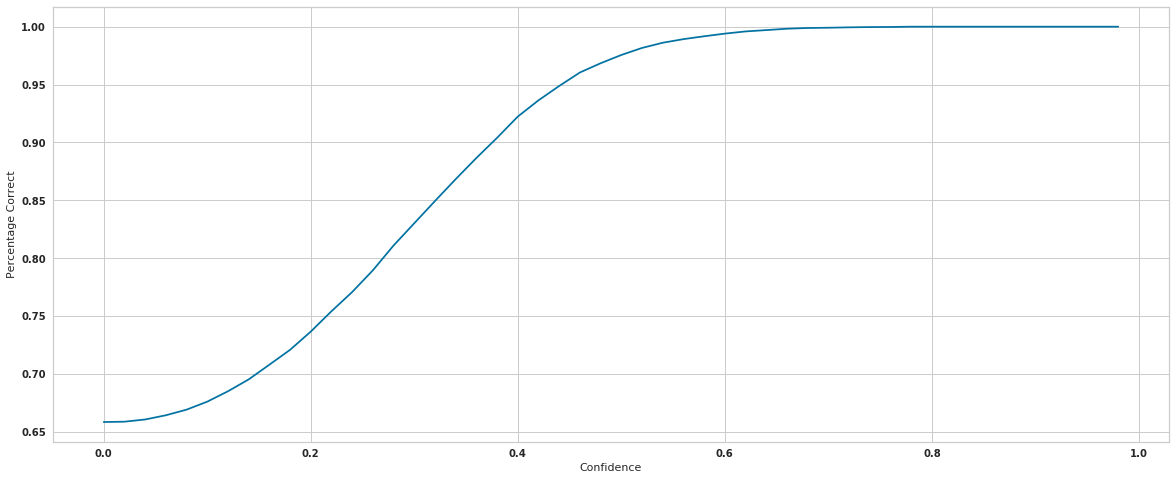

In [38]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

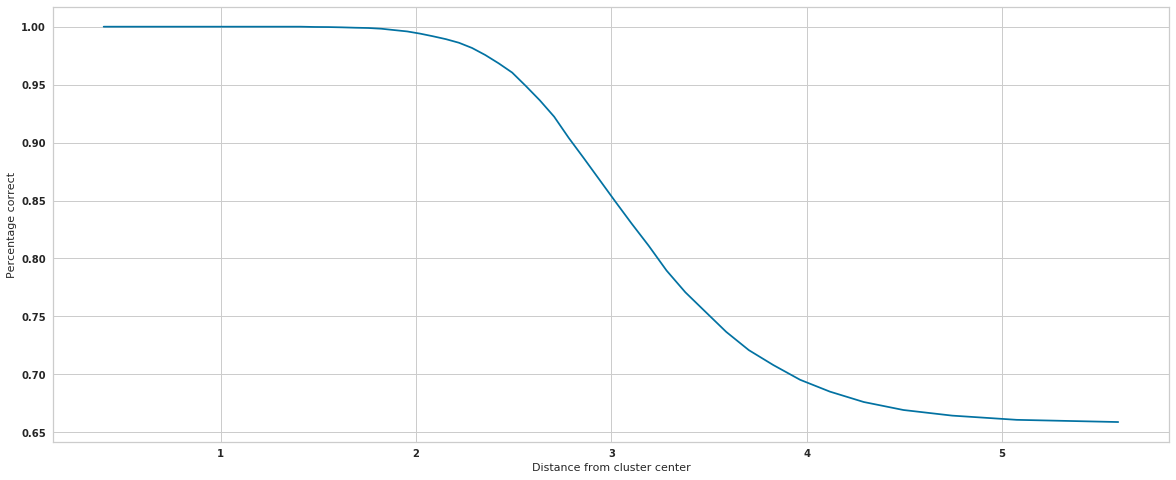

In [39]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [40]:
from shutil import copy2

In [41]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

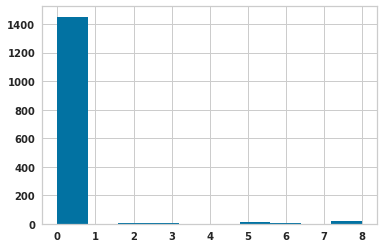

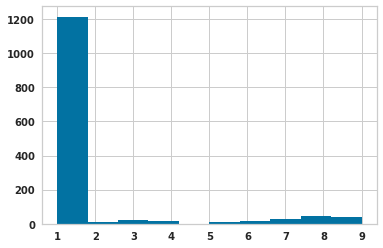

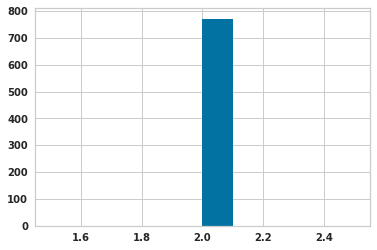

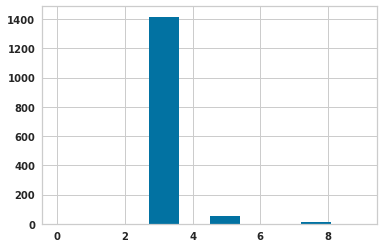

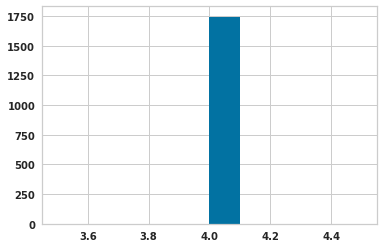

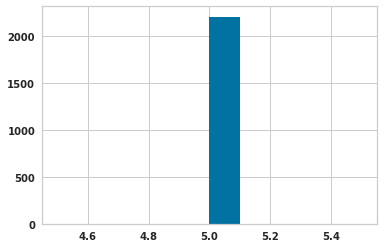

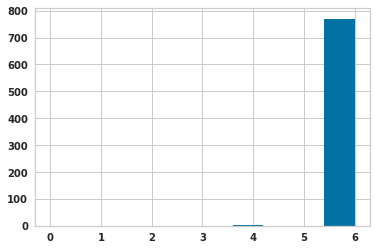

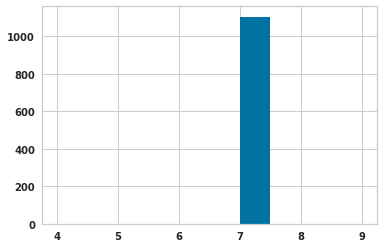

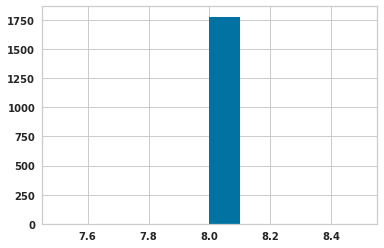

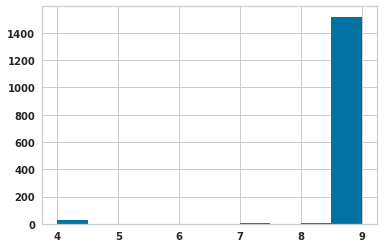

In [42]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [43]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9', 'cluster_level_2',
       'distance_level_2_2_0', 'distance_level_2_2_1', 'distance_level_2_2_2',
       'distance_level_2_2_3', 'distance_level_2_2_4', 'distance_level_2_2_5',
       'distance_level_2_2_6', 'distance_level_2_2_7', 'distance_level_2_2_8',
       'distance_level_2_2_9', 'distance_level_2_4_0', 'distance_level_2_4_1',
       'distance_level_2_4_2', 'distance_level_2_4_3', 'distance_level_2_4_4',
       'distance_level_2_4_5', 'distance_level_2_4_6', 'distance_level_2_4_7',
       'dis

# Iteration 2

In [44]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 24550.780603936837
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 1/62, Nll_loss : 133.30291748046875 KLD:8.604765892028809  Supervised loss:0.4318554699420929
Epoch: 1/63, Nll_loss : 149.50823974609375 KLD:9.012075424194336  Supervised loss:0.31225019693374634
Epoch: 1/64, Nll_loss : 138.27120971679688 KLD:8.70504379272461  Supervised loss:0.41452717781066895
Epoch: 1/65, Nll_loss : 137.968505859375 KLD:8.790797233581543  Supervised loss:0.4413700997829437
Epoch: 1/66, Nll_loss : 141.44900512695312 KLD:8.896000862121582  Supervised loss:0.5198840498924255
Epoch: 1/67, Nll_loss : 125.77056121826172 KLD:8.789836883544922  Supervised loss:0.39933305978775024
Epoch: 1/68, Nll_loss : 128.48379516601562 KLD:8.15255355834961  Supervised loss:0.4287357032299042
Epoch: 1/69, Nll_loss : 136.8641357421875 KLD:8.96170711517334  Supervised loss:0.5636054277420044
Epoch: 1/70, Nll_loss : 147.22230529785156 KLD:8.635673522949219  Supervised loss:0.5407198667526245
Epoch: 1/71, Nll_loss : 135.177734375 KLD:8.787453651428223  Supervised loss:0.366908520460128

Epoch: 1/146, Nll_loss : 132.8088836669922 KLD:9.024310111999512  Supervised loss:0.5330464839935303
Epoch: 1/147, Nll_loss : 125.48521423339844 KLD:9.807109832763672  Supervised loss:0.34560564160346985
Epoch: 1/148, Nll_loss : 134.767578125 KLD:9.72581958770752  Supervised loss:0.4025226831436157
Epoch: 1/149, Nll_loss : 138.6253662109375 KLD:9.472166061401367  Supervised loss:0.4349452257156372
Epoch: 1/150, Nll_loss : 129.27735900878906 KLD:9.143502235412598  Supervised loss:0.32769227027893066
Epoch: 1/151, Nll_loss : 137.27474975585938 KLD:9.549631118774414  Supervised loss:0.4044341742992401
Epoch: 1/152, Nll_loss : 130.87852478027344 KLD:8.964085578918457  Supervised loss:0.41522684693336487
Epoch: 1/153, Nll_loss : 132.78167724609375 KLD:8.76878547668457  Supervised loss:0.3359222412109375
Epoch: 1/154, Nll_loss : 127.93019104003906 KLD:9.03495979309082  Supervised loss:0.28884172439575195
Epoch: 1/155, Nll_loss : 139.66143798828125 KLD:8.5657958984375  Supervised loss:0.36014

Epoch: 1/227, Nll_loss : 131.39999389648438 KLD:9.484697341918945  Supervised loss:0.3072105050086975
Epoch: 1/228, Nll_loss : 134.59483337402344 KLD:8.820579528808594  Supervised loss:0.34467944502830505
Epoch: 1/229, Nll_loss : 133.0218963623047 KLD:9.05860710144043  Supervised loss:0.4911162853240967
Epoch: 1/230, Nll_loss : 130.37661743164062 KLD:9.262578964233398  Supervised loss:0.4064069986343384
Epoch: 1/231, Nll_loss : 134.7866668701172 KLD:8.756461143493652  Supervised loss:0.4001619219779968
Epoch: 1/232, Nll_loss : 135.8827362060547 KLD:9.002544403076172  Supervised loss:0.4633691608905792
Epoch: 1/233, Nll_loss : 129.2337188720703 KLD:9.133737564086914  Supervised loss:0.2960405945777893
Epoch: 1/234, Nll_loss : 130.4649658203125 KLD:9.674613952636719  Supervised loss:0.3451215624809265
Epoch: 1/235, Nll_loss : 135.2405548095703 KLD:9.083369255065918  Supervised loss:0.35661160945892334
Epoch: 1/236, Nll_loss : 135.04612731933594 KLD:9.33612060546875  Supervised loss:0.322

Epoch: 1/308, Nll_loss : 123.15261840820312 KLD:9.089029312133789  Supervised loss:0.22249546647071838
Epoch: 1/309, Nll_loss : 139.73171997070312 KLD:9.06594467163086  Supervised loss:0.3525463044643402
Epoch: 1/310, Nll_loss : 126.67343139648438 KLD:8.46873664855957  Supervised loss:0.28416064381599426
Epoch: 1/311, Nll_loss : 142.44908142089844 KLD:8.757843017578125  Supervised loss:0.4188991189002991
Epoch: 1/312, Nll_loss : 136.12632751464844 KLD:9.095792770385742  Supervised loss:0.44859468936920166
Epoch: 1/313, Nll_loss : 136.36911010742188 KLD:9.305851936340332  Supervised loss:0.3347971439361572
Epoch: 1/314, Nll_loss : 131.10610961914062 KLD:9.210139274597168  Supervised loss:0.3362252712249756
Epoch: 1/315, Nll_loss : 124.78141784667969 KLD:9.402769088745117  Supervised loss:0.3786824941635132
Epoch: 1/316, Nll_loss : 126.6892318725586 KLD:9.464975357055664  Supervised loss:0.314411997795105
Epoch: 1/317, Nll_loss : 127.80020141601562 KLD:9.358975410461426  Supervised loss:

Epoch: 1/389, Nll_loss : 130.28421020507812 KLD:9.723273277282715  Supervised loss:0.29953035712242126
Epoch: 1/390, Nll_loss : 124.8650131225586 KLD:9.661951065063477  Supervised loss:0.23224271833896637
Epoch: 1/391, Nll_loss : 130.16192626953125 KLD:10.330132484436035  Supervised loss:0.2692776918411255
Epoch: 1/392, Nll_loss : 124.26840209960938 KLD:9.881239891052246  Supervised loss:0.3172827959060669
Epoch: 1/393, Nll_loss : 125.27484130859375 KLD:9.84992790222168  Supervised loss:0.21856877207756042
Epoch: 1/394, Nll_loss : 133.41635131835938 KLD:9.575728416442871  Supervised loss:0.3530670404434204
Epoch: 1/395, Nll_loss : 129.03793334960938 KLD:9.29322624206543  Supervised loss:0.282065749168396
Epoch: 1/396, Nll_loss : 125.66957092285156 KLD:9.074373245239258  Supervised loss:0.45612457394599915
Epoch: 1/397, Nll_loss : 128.31121826171875 KLD:9.189619064331055  Supervised loss:0.3151393532752991
Epoch: 1/398, Nll_loss : 121.52622985839844 KLD:8.741573333740234  Supervised los

Epoch: 1/470, Nll_loss : 125.66973876953125 KLD:9.386449813842773  Supervised loss:0.2576664686203003
Epoch: 1/471, Nll_loss : 126.88212585449219 KLD:9.48054313659668  Supervised loss:0.21072527766227722
Epoch: 1/472, Nll_loss : 125.40518188476562 KLD:9.310660362243652  Supervised loss:0.2790535092353821
Epoch: 1/473, Nll_loss : 130.23358154296875 KLD:9.298578262329102  Supervised loss:0.31616538763046265
Epoch: 1/474, Nll_loss : 125.04727935791016 KLD:9.201841354370117  Supervised loss:0.3230988085269928
Epoch: 1/475, Nll_loss : 123.23603057861328 KLD:9.234829902648926  Supervised loss:0.29525142908096313
Epoch: 1/476, Nll_loss : 129.84014892578125 KLD:9.526144027709961  Supervised loss:0.31700754165649414
Epoch: 1/477, Nll_loss : 123.59591674804688 KLD:9.805543899536133  Supervised loss:0.2404678761959076
Epoch: 1/478, Nll_loss : 126.23502349853516 KLD:9.54761791229248  Supervised loss:0.3117281198501587
Epoch: 1/479, Nll_loss : 125.35476684570312 KLD:9.304277420043945  Supervised lo

Epoch: 1/553, Nll_loss : 119.19859313964844 KLD:8.965341567993164  Supervised loss:0.3304920494556427
Epoch: 1/554, Nll_loss : 129.62832641601562 KLD:9.15489673614502  Supervised loss:0.37196874618530273
Epoch: 1/555, Nll_loss : 127.08340454101562 KLD:8.820981979370117  Supervised loss:0.31379324197769165
Epoch: 1/556, Nll_loss : 129.95016479492188 KLD:9.114381790161133  Supervised loss:0.29299527406692505
Epoch: 1/557, Nll_loss : 131.79586791992188 KLD:9.27098560333252  Supervised loss:0.30352604389190674
Epoch: 1/558, Nll_loss : 122.61466979980469 KLD:9.378726959228516  Supervised loss:0.30627816915512085
Epoch: 1/559, Nll_loss : 122.75041198730469 KLD:9.168330192565918  Supervised loss:0.33728569746017456
Epoch: 1/560, Nll_loss : 123.11909484863281 KLD:9.458597183227539  Supervised loss:0.23646295070648193
Epoch: 1/561, Nll_loss : 122.17662811279297 KLD:9.237306594848633  Supervised loss:0.31367164850234985
Epoch: 1/562, Nll_loss : 119.14787292480469 KLD:9.324808120727539  Supervise

Epoch: 1/634, Nll_loss : 123.07365417480469 KLD:9.013484954833984  Supervised loss:0.28551173210144043
Epoch: 1/635, Nll_loss : 124.66743469238281 KLD:8.679975509643555  Supervised loss:0.3661841154098511
Epoch: 1/636, Nll_loss : 129.0896453857422 KLD:9.016647338867188  Supervised loss:0.2735985517501831
Epoch: 1/637, Nll_loss : 120.39431762695312 KLD:9.625255584716797  Supervised loss:0.23474161326885223
Epoch: 1/638, Nll_loss : 117.96884155273438 KLD:9.470050811767578  Supervised loss:0.34905239939689636
Epoch: 1/639, Nll_loss : 125.94274139404297 KLD:9.428062438964844  Supervised loss:0.3057854175567627
Epoch: 1/640, Nll_loss : 132.6988525390625 KLD:9.729496002197266  Supervised loss:0.35054296255111694
Epoch: 1/641, Nll_loss : 121.10939025878906 KLD:9.628023147583008  Supervised loss:0.2804329991340637
Epoch: 1/642, Nll_loss : 120.47969055175781 KLD:9.823970794677734  Supervised loss:0.31572622060775757
Epoch: 1/643, Nll_loss : 134.2945556640625 KLD:9.752875328063965  Supervised lo

Epoch: 1/715, Nll_loss : 123.90316772460938 KLD:9.196651458740234  Supervised loss:0.28917503356933594
Epoch: 1/716, Nll_loss : 123.02217102050781 KLD:8.83158016204834  Supervised loss:0.28305017948150635
Epoch: 1/717, Nll_loss : 122.30853271484375 KLD:9.120320320129395  Supervised loss:0.2597704827785492
Epoch: 1/718, Nll_loss : 131.49960327148438 KLD:9.755067825317383  Supervised loss:0.32659658789634705
Epoch: 1/719, Nll_loss : 118.79716491699219 KLD:9.593696594238281  Supervised loss:0.30464571714401245
Epoch: 1/720, Nll_loss : 125.54312133789062 KLD:9.21290397644043  Supervised loss:0.35166409611701965
Epoch: 1/721, Nll_loss : 124.27581787109375 KLD:9.654706001281738  Supervised loss:0.32288163900375366
Epoch: 1/722, Nll_loss : 123.51031494140625 KLD:9.43818473815918  Supervised loss:0.31666409969329834
Epoch: 1/723, Nll_loss : 118.19197082519531 KLD:9.556771278381348  Supervised loss:0.3821007311344147
Epoch: 1/724, Nll_loss : 124.92586517333984 KLD:10.13608169555664  Supervised 

Epoch: 1/796, Nll_loss : 127.98759460449219 KLD:8.470024108886719  Supervised loss:0.259458065032959
Epoch: 1/797, Nll_loss : 135.90399169921875 KLD:8.634626388549805  Supervised loss:0.2782408893108368
Epoch: 1/798, Nll_loss : 127.74803161621094 KLD:8.640251159667969  Supervised loss:0.3677428960800171
Epoch: 1/799, Nll_loss : 128.05242919921875 KLD:8.459917068481445  Supervised loss:0.46346575021743774
Epoch: 1/800, Nll_loss : 134.1439208984375 KLD:9.028867721557617  Supervised loss:0.4175284504890442
Epoch: 1/801, Nll_loss : 126.11293029785156 KLD:9.545143127441406  Supervised loss:0.32730740308761597
Epoch: 1/802, Nll_loss : 116.64925384521484 KLD:9.29343032836914  Supervised loss:0.4071991443634033
Epoch: 1/803, Nll_loss : 121.94291687011719 KLD:9.809492111206055  Supervised loss:0.31141898036003113
Epoch: 1/804, Nll_loss : 121.07868957519531 KLD:9.63150405883789  Supervised loss:0.2569006383419037
Epoch: 1/805, Nll_loss : 121.70014953613281 KLD:10.143082618713379  Supervised loss

Epoch: 1/877, Nll_loss : 117.69609069824219 KLD:10.077178955078125  Supervised loss:0.27098536491394043
Epoch: 1/878, Nll_loss : 124.25971984863281 KLD:10.369210243225098  Supervised loss:0.3317420482635498
Epoch: 1/879, Nll_loss : 127.58842468261719 KLD:10.157533645629883  Supervised loss:0.2747876048088074
Epoch: 1/880, Nll_loss : 113.59086608886719 KLD:10.082147598266602  Supervised loss:0.25527116656303406
Epoch: 1/881, Nll_loss : 120.11074829101562 KLD:9.4248685836792  Supervised loss:0.2581329941749573
Epoch: 1/882, Nll_loss : 120.99092102050781 KLD:9.752948760986328  Supervised loss:0.2499752938747406
Epoch: 1/883, Nll_loss : 124.2843017578125 KLD:9.347219467163086  Supervised loss:0.28058576583862305
Epoch: 1/884, Nll_loss : 115.25790405273438 KLD:9.381681442260742  Supervised loss:0.2560855746269226
Epoch: 1/885, Nll_loss : 126.44964599609375 KLD:9.346739768981934  Supervised loss:0.33078712224960327
Epoch: 1/886, Nll_loss : 120.32760620117188 KLD:9.08967399597168  Supervised 

In [45]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

In [46]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=46 z_min=-4.6596007 z_max=4.260607
Latent vectors shape (59840, 10)


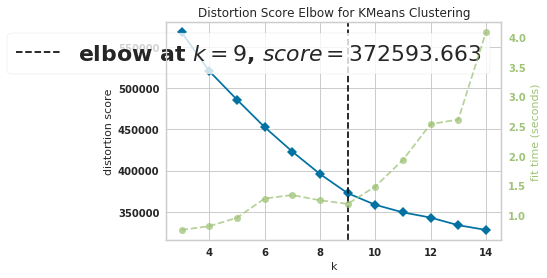

In [47]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

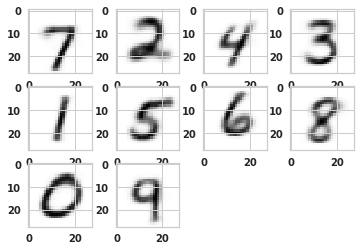

In [48]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [49]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 2, 4, 3,
                                           1, 5, 6, 8,
                                           0, 9
                                          ]
manual_annotation_json["manual_confidence"] = [1, 0.9, 0.8, 1,
                                               1, 0.9, 1, 1,
                                               1,0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [50]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [51]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

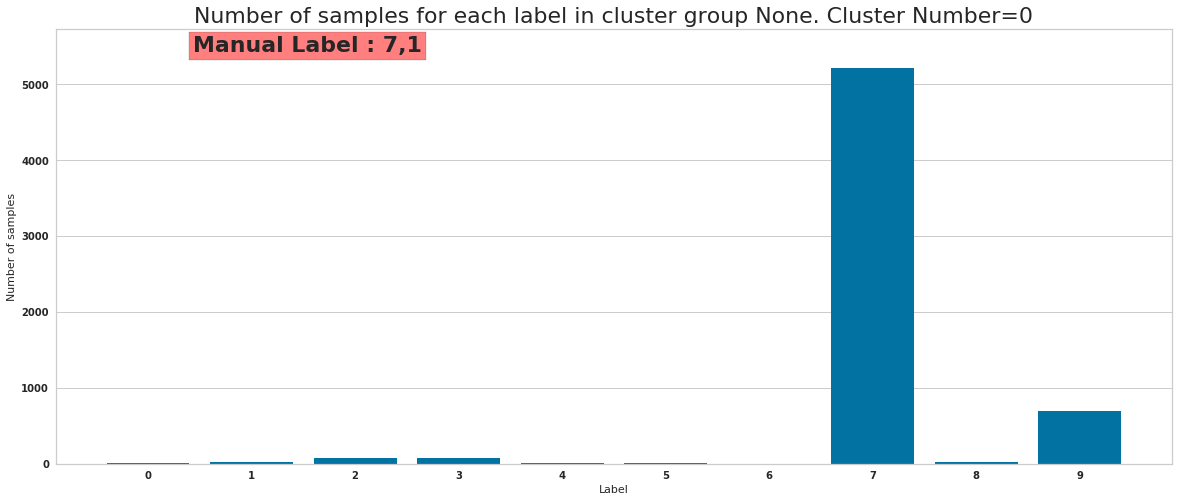

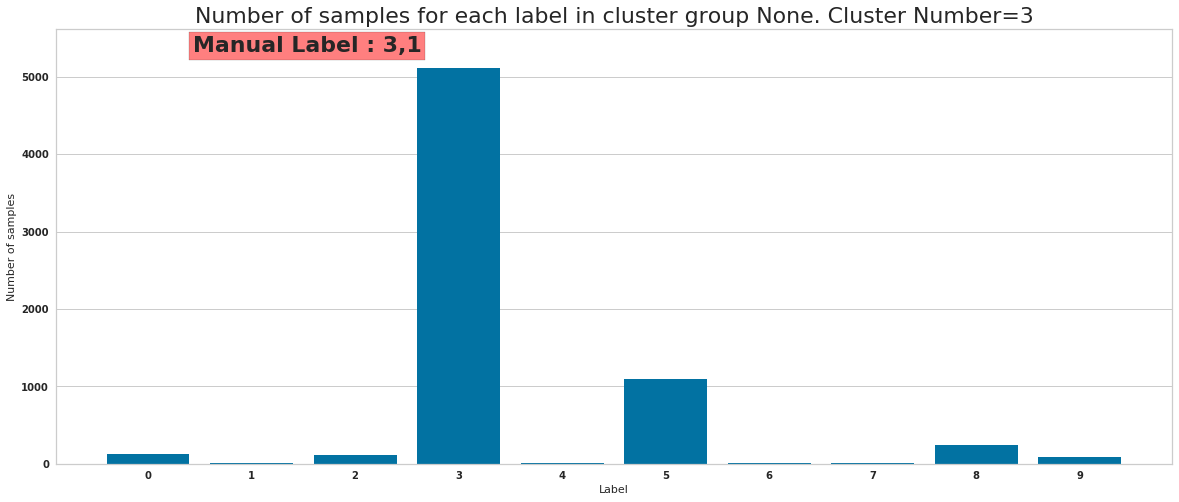

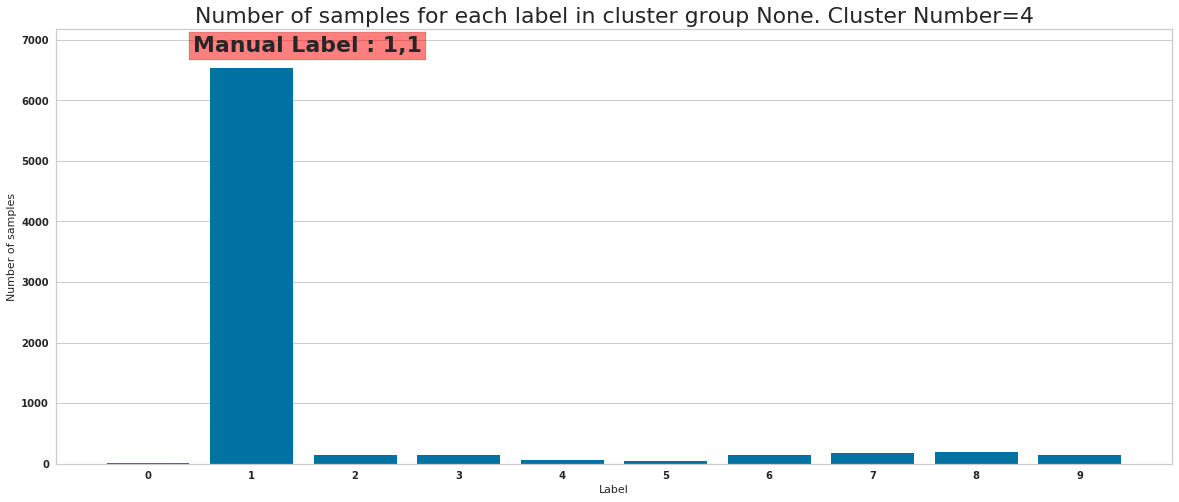

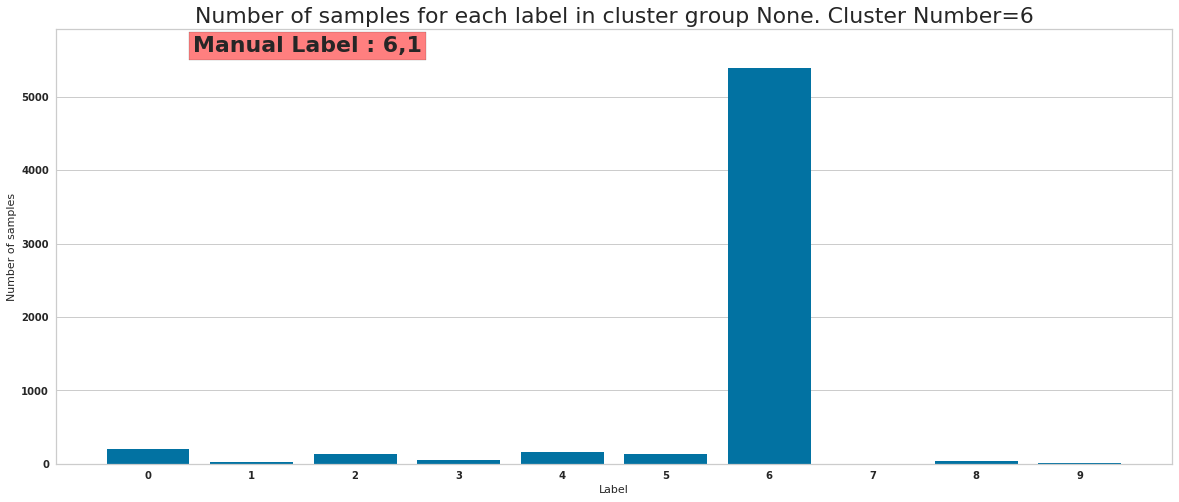

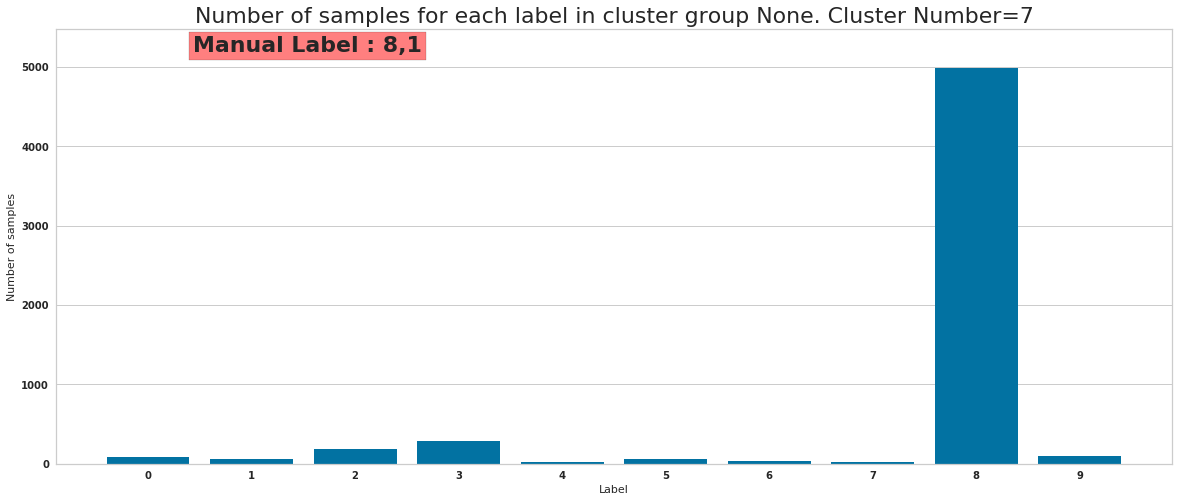

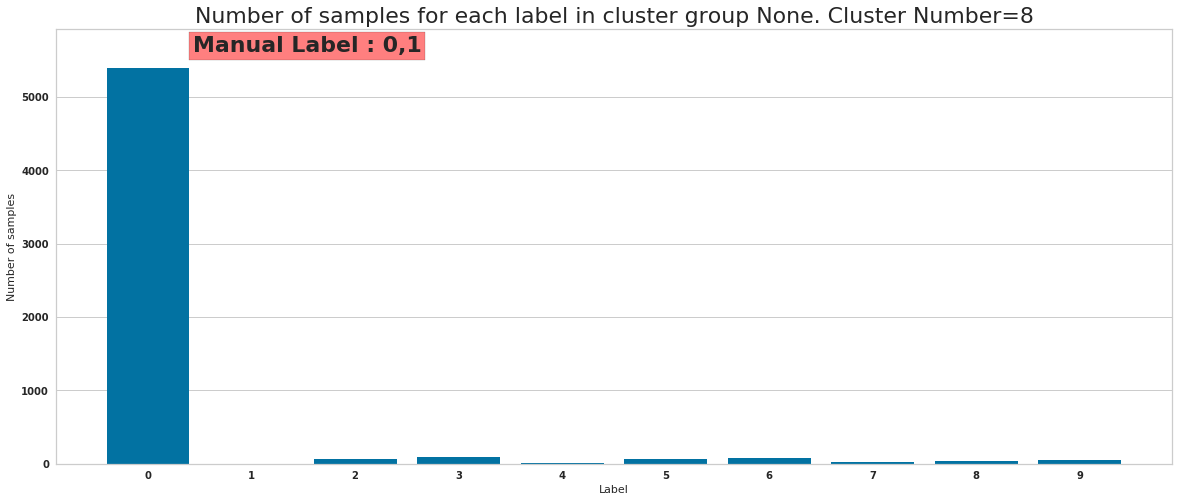

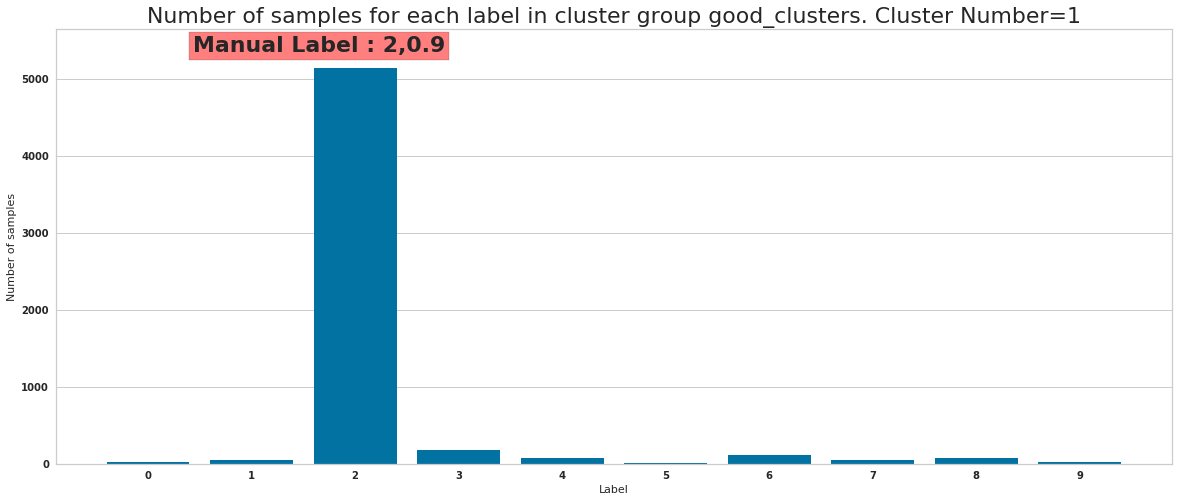

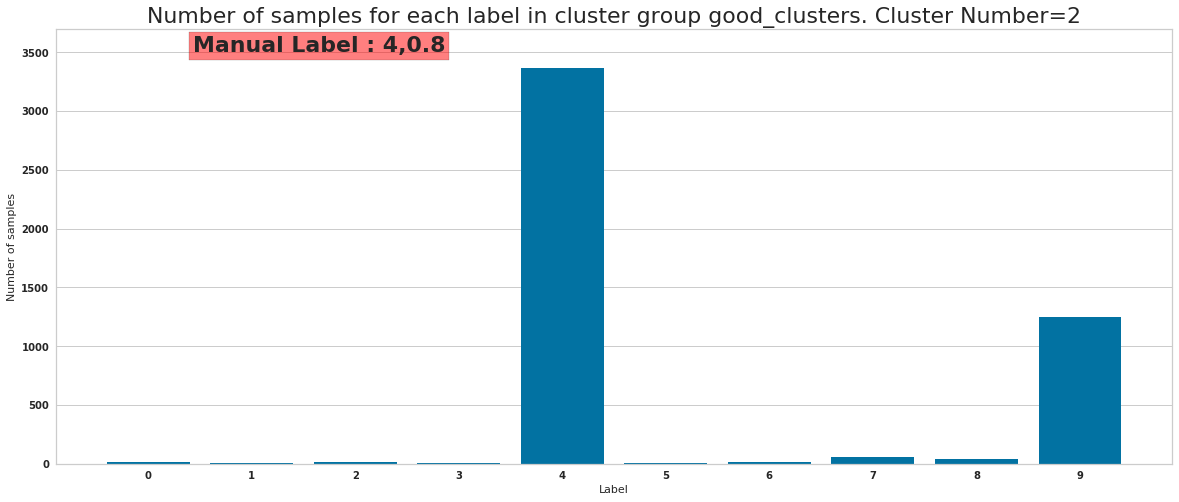

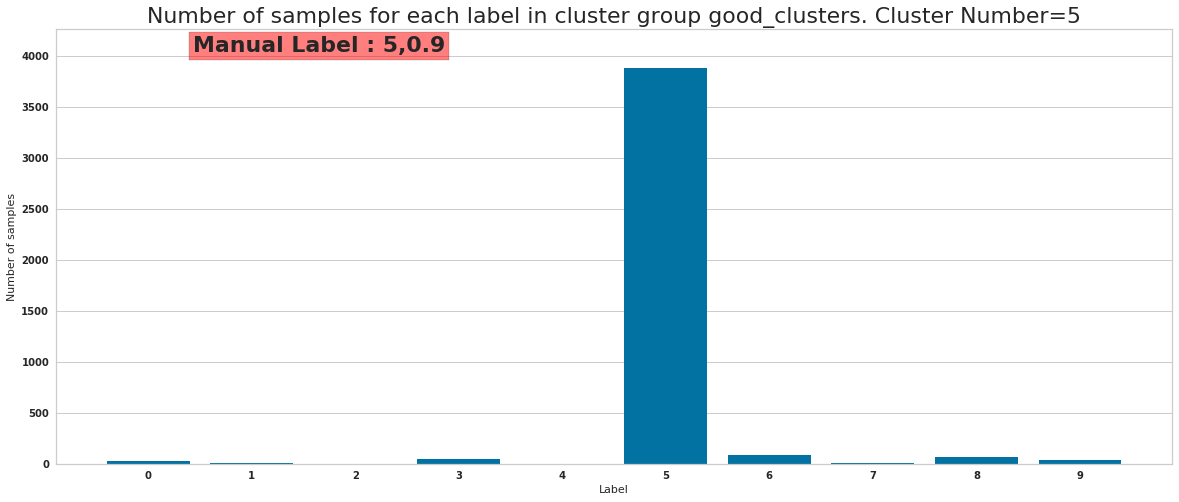

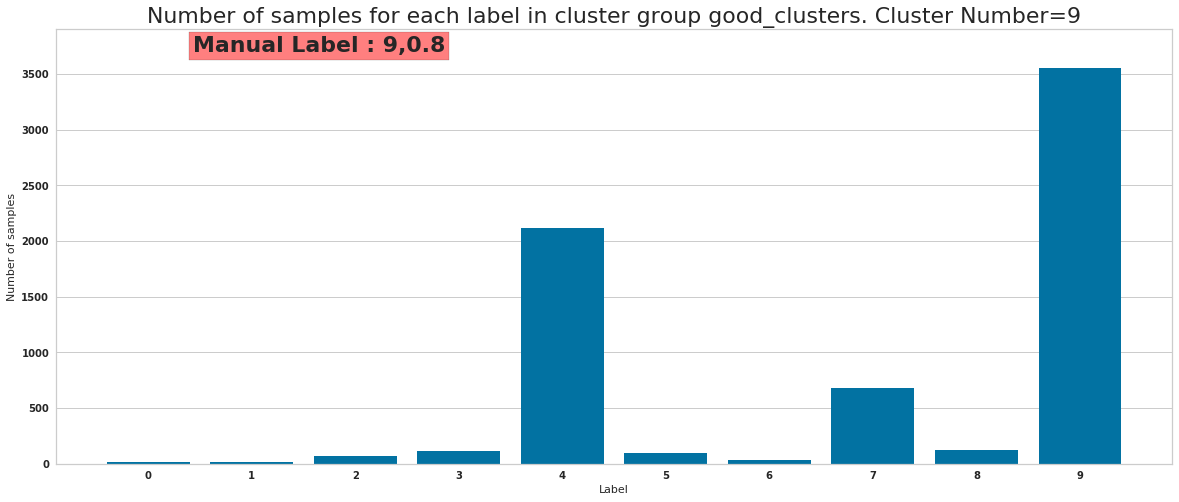

In [52]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [53]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(6123, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5732, 10)
(4770, 10)
(6805, 10)
(7608, 10)
(4170, 10)
(6142, 10)
(5842, 10)
(5827, 10)
(6821, 10)


In [54]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [55]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,3,0,5,
#                                         -1,5,-1,-1,
#                                         -1,8]
# level_2_cluster_dict["manual_confidences"] = [0,0.7,0.9,0.6,
#                                              0,0.6,0,0,
#                                              0, 0.7]
# level2_manual_annotations[0] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [56]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 7
(6123, 47) (6123, 33)
Num correct=5210
Cluster 0 Manual Label 7 Percentage correct 85.08900865588764
********************************
Manual Label 2
(5732, 47) (5732, 33)
Num correct=5138
Cluster 1 Manual Label 2 Percentage correct 89.63712491277042
********************************
Manual Label 4
(4770, 47) (4770, 33)
Num correct=3363
Cluster 2 Manual Label 4 Percentage correct 70.50314465408805
********************************
Manual Label 3
(6805, 47) (6805, 33)
Num correct=5106
Cluster 3 Manual Label 3 Percentage correct 75.0330639235856
********************************
Manual Label 1
(7608, 47) (7608, 33)
Num correct=6526
Cluster 4 Manual Label 1 Percentage correct 85.77812828601472
********************************
Manual Label 5
(4170, 47) (4170, 33)
Num correct=3877
Cluster 5 Manual Label 5 Percentage correct 92.97362110311751
********************************
Manual Label 6
(6142, 47) (6142, 33)
Num correct=5385
Cluster 6 Manual Label 6 Percentage correct 87.675024

In [57]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([6123., 5732., 4770., 6805., 7608., 4170., 6142., 5842., 5827.,
        6821.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

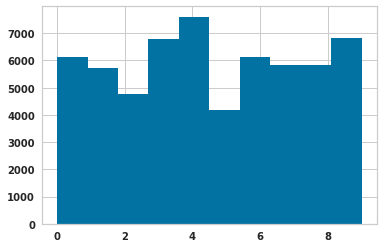

In [58]:
plt.hist(cluster_labels)

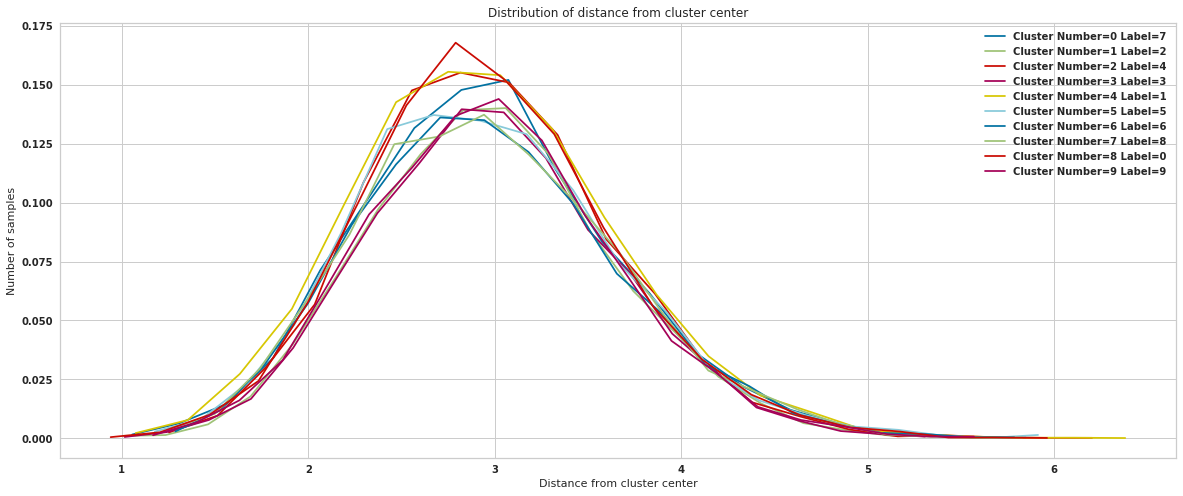

In [59]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

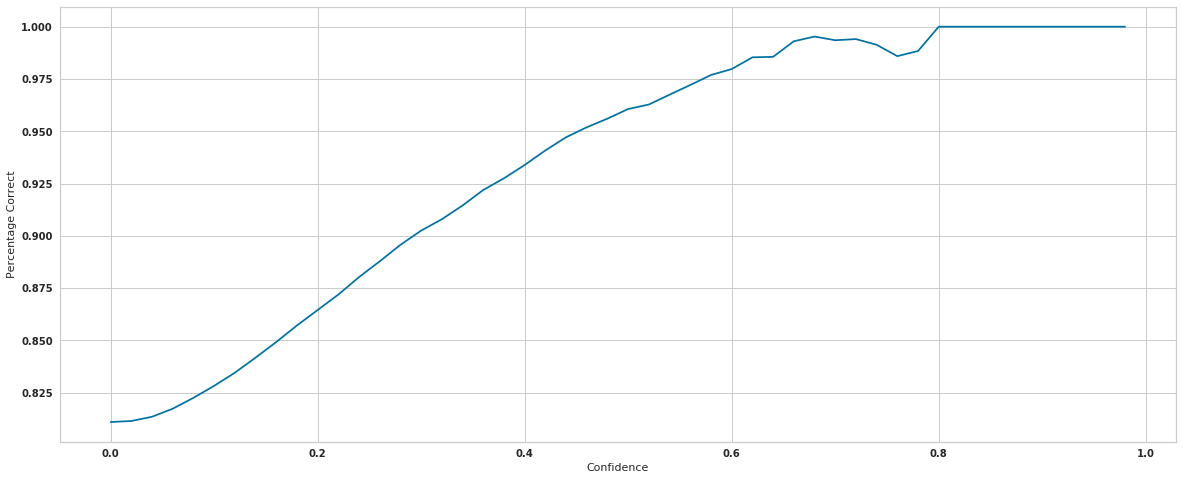

In [60]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

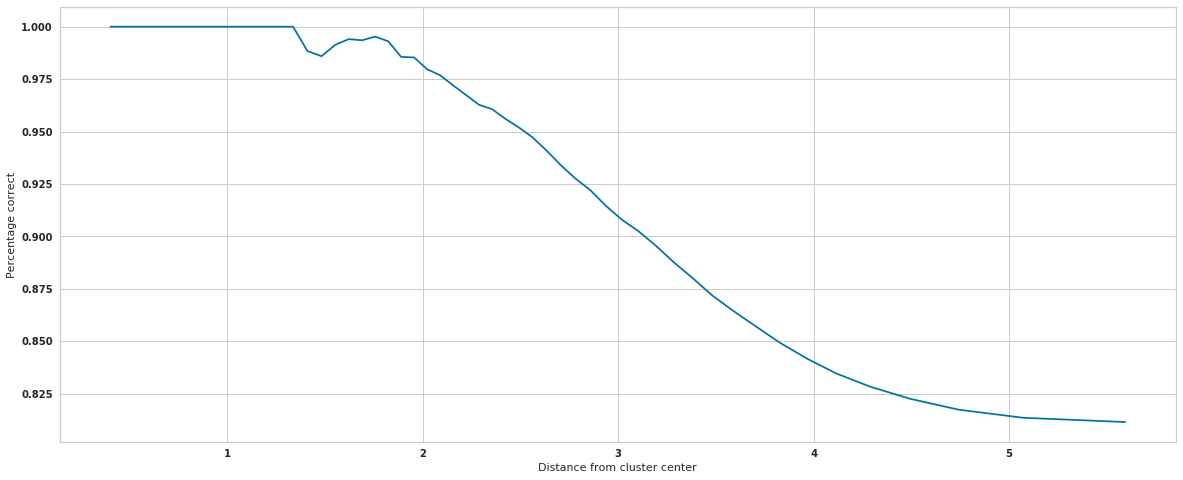

In [61]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [62]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

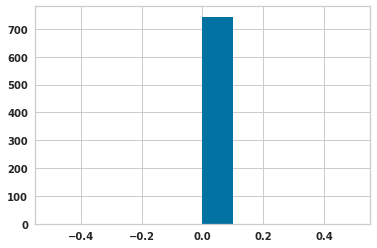

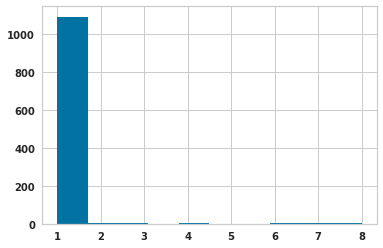

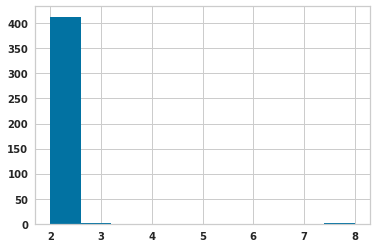

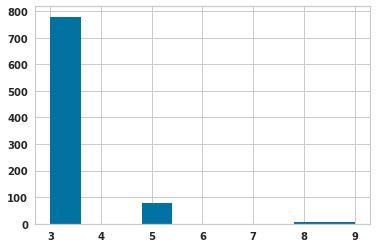

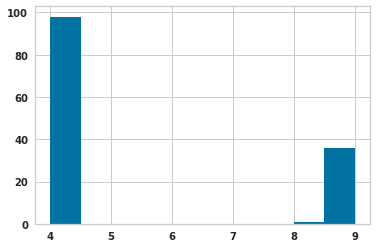

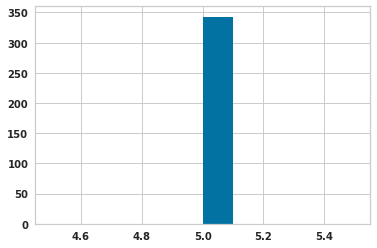

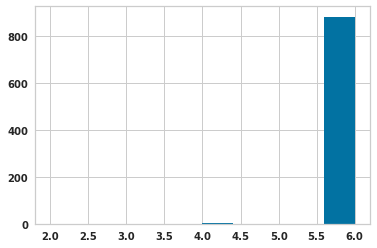

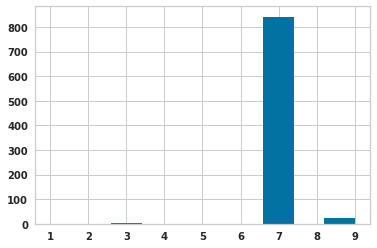

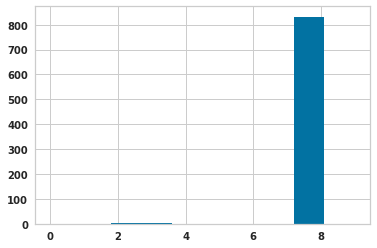

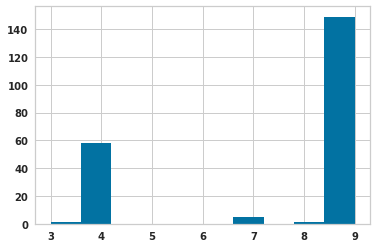

In [63]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [64]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [65]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [66]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 18400.136231468892
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 2/61, Nll_loss : 121.55753326416016 KLD:9.231199264526367  Supervised loss:0.1384696364402771
Epoch: 2/62, Nll_loss : 132.2688446044922 KLD:9.53985595703125  Supervised loss:0.12559768557548523
Epoch: 2/63, Nll_loss : 125.85879516601562 KLD:9.159233093261719  Supervised loss:0.13492950797080994
Epoch: 2/64, Nll_loss : 123.1563720703125 KLD:8.97114086151123  Supervised loss:0.10606223344802856
Epoch: 2/65, Nll_loss : 129.590087890625 KLD:9.673929214477539  Supervised loss:0.1120498925447464
Epoch: 2/66, Nll_loss : 113.56520080566406 KLD:9.228558540344238  Supervised loss:0.09198971092700958
Epoch: 2/67, Nll_loss : 116.08190155029297 KLD:8.71359920501709  Supervised loss:0.12230291962623596
Epoch: 2/68, Nll_loss : 125.095458984375 KLD:9.253411293029785  Supervised loss:0.12457175552845001
Epoch: 2/69, Nll_loss : 131.15484619140625 KLD:9.356961250305176  Supervised loss:0.10799722373485565
Epoch: 2/70, Nll_loss : 119.4980239868164 KLD:9.206825256347656  Supervised loss:0.1321190595

Epoch: 2/142, Nll_loss : 125.49388122558594 KLD:9.495000839233398  Supervised loss:0.1347569078207016
Epoch: 2/143, Nll_loss : 119.94442749023438 KLD:9.160209655761719  Supervised loss:0.09566760063171387
Epoch: 2/144, Nll_loss : 119.85701751708984 KLD:9.278728485107422  Supervised loss:0.11424237489700317
Epoch: 2/145, Nll_loss : 125.28226470947266 KLD:8.848991394042969  Supervised loss:0.12294141203165054
Epoch: 2/146, Nll_loss : 118.33898162841797 KLD:9.579605102539062  Supervised loss:0.11168724298477173
Epoch: 2/147, Nll_loss : 125.84230041503906 KLD:9.53653335571289  Supervised loss:0.12253554910421371
Epoch: 2/148, Nll_loss : 127.93832397460938 KLD:9.40693473815918  Supervised loss:0.1210193783044815
Epoch: 2/149, Nll_loss : 117.68976593017578 KLD:9.177534103393555  Supervised loss:0.11332826316356659
Epoch: 2/150, Nll_loss : 125.73614501953125 KLD:9.868124961853027  Supervised loss:0.11649896949529648
Epoch: 2/151, Nll_loss : 118.8067398071289 KLD:9.38320541381836  Supervised l

Epoch: 2/223, Nll_loss : 122.7704086303711 KLD:8.925929069519043  Supervised loss:0.16401393711566925
Epoch: 2/224, Nll_loss : 126.47838592529297 KLD:9.5238037109375  Supervised loss:0.11422848701477051
Epoch: 2/225, Nll_loss : 131.1164093017578 KLD:9.177206993103027  Supervised loss:0.16399353742599487
Epoch: 2/226, Nll_loss : 123.63650512695312 KLD:9.288368225097656  Supervised loss:0.0937647819519043
Epoch: 2/227, Nll_loss : 122.28469848632812 KLD:9.153308868408203  Supervised loss:0.11772286891937256
Epoch: 2/228, Nll_loss : 129.11380004882812 KLD:9.44787883758545  Supervised loss:0.12246866524219513
Epoch: 2/229, Nll_loss : 118.07754516601562 KLD:9.743059158325195  Supervised loss:0.09014468640089035
Epoch: 2/230, Nll_loss : 124.68009948730469 KLD:9.399662017822266  Supervised loss:0.11227022111415863
Epoch: 2/231, Nll_loss : 126.01301574707031 KLD:9.81865119934082  Supervised loss:0.10438612103462219
Epoch: 2/232, Nll_loss : 118.41822814941406 KLD:9.840010643005371  Supervised lo

Epoch: 2/303, Nll_loss : 125.08019256591797 KLD:8.797041893005371  Supervised loss:0.1050635278224945
Epoch: 2/304, Nll_loss : 124.04560089111328 KLD:8.98354721069336  Supervised loss:0.1267785131931305
Epoch: 2/305, Nll_loss : 118.21807861328125 KLD:8.7974271774292  Supervised loss:0.11166486144065857
Epoch: 2/306, Nll_loss : 124.98507690429688 KLD:9.051206588745117  Supervised loss:0.15588116645812988
Epoch: 2/307, Nll_loss : 116.57807922363281 KLD:9.168792724609375  Supervised loss:0.08205153793096542
Epoch: 2/308, Nll_loss : 130.65737915039062 KLD:9.325447082519531  Supervised loss:0.09179437905550003
Epoch: 2/309, Nll_loss : 119.88166809082031 KLD:8.914617538452148  Supervised loss:0.07740134745836258
Epoch: 2/310, Nll_loss : 133.48422241210938 KLD:9.203004837036133  Supervised loss:0.13767237961292267
Epoch: 2/311, Nll_loss : 128.83016967773438 KLD:9.351043701171875  Supervised loss:0.13267222046852112
Epoch: 2/312, Nll_loss : 127.68212890625 KLD:9.596004486083984  Supervised los

Epoch: 2/384, Nll_loss : 130.45806884765625 KLD:9.639034271240234  Supervised loss:0.1087547242641449
Epoch: 2/385, Nll_loss : 127.53594207763672 KLD:9.636367797851562  Supervised loss:0.12420254200696945
Epoch: 2/386, Nll_loss : 121.5009765625 KLD:9.900094985961914  Supervised loss:0.0792163535952568
Epoch: 2/387, Nll_loss : 115.9840316772461 KLD:9.294055938720703  Supervised loss:0.11956924200057983
Epoch: 2/388, Nll_loss : 122.40306854248047 KLD:9.39132022857666  Supervised loss:0.11576773971319199
Epoch: 2/389, Nll_loss : 119.64306640625 KLD:9.277698516845703  Supervised loss:0.10420851409435272
Epoch: 2/390, Nll_loss : 122.87459564208984 KLD:9.61149787902832  Supervised loss:0.09167627990245819
Epoch: 2/391, Nll_loss : 118.18644714355469 KLD:9.367382049560547  Supervised loss:0.12177446484565735
Epoch: 2/392, Nll_loss : 119.01074981689453 KLD:9.692750930786133  Supervised loss:0.10761474072933197
Epoch: 2/393, Nll_loss : 125.66495513916016 KLD:9.886767387390137  Supervised loss:0.

Epoch: 2/465, Nll_loss : 126.020263671875 KLD:9.168697357177734  Supervised loss:0.09323674440383911
Epoch: 2/466, Nll_loss : 120.720458984375 KLD:9.059967041015625  Supervised loss:0.11311391741037369
Epoch: 2/467, Nll_loss : 116.28670501708984 KLD:9.312821388244629  Supervised loss:0.09537234902381897
Epoch: 2/468, Nll_loss : 122.7962875366211 KLD:9.08641242980957  Supervised loss:0.11522354185581207
Epoch: 2/469, Nll_loss : 116.53556823730469 KLD:9.162020683288574  Supervised loss:0.12391536682844162
Epoch: 2/470, Nll_loss : 116.25389862060547 KLD:9.45718765258789  Supervised loss:0.10813967883586884
Epoch: 2/471, Nll_loss : 119.25511932373047 KLD:9.341974258422852  Supervised loss:0.07943249493837357
Epoch: 2/472, Nll_loss : 121.29400634765625 KLD:9.290477752685547  Supervised loss:0.08780515193939209
Epoch: 2/473, Nll_loss : 118.99125671386719 KLD:9.228755950927734  Supervised loss:0.10071314871311188
Epoch: 2/474, Nll_loss : 118.32492065429688 KLD:9.036093711853027  Supervised lo

Epoch: 2/546, Nll_loss : 121.69808197021484 KLD:9.27629280090332  Supervised loss:0.097446009516716
Epoch: 2/547, Nll_loss : 124.71981811523438 KLD:9.117990493774414  Supervised loss:0.11344604194164276
Epoch: 2/548, Nll_loss : 116.31957244873047 KLD:9.250041961669922  Supervised loss:0.09643587470054626
Epoch: 2/549, Nll_loss : 113.53939819335938 KLD:9.230751991271973  Supervised loss:0.10044047236442566
Epoch: 2/550, Nll_loss : 117.41850280761719 KLD:9.303262710571289  Supervised loss:0.09442032873630524
Epoch: 2/551, Nll_loss : 120.3788070678711 KLD:9.315685272216797  Supervised loss:0.10847142338752747
Epoch: 2/552, Nll_loss : 111.919921875 KLD:8.929187774658203  Supervised loss:0.08481572568416595
Epoch: 2/553, Nll_loss : 125.40792083740234 KLD:9.105691909790039  Supervised loss:0.11152631044387817
Epoch: 2/554, Nll_loss : 124.21088409423828 KLD:8.831480979919434  Supervised loss:0.1220700666308403
Epoch: 2/555, Nll_loss : 122.80082702636719 KLD:9.196500778198242  Supervised loss:

Epoch: 2/627, Nll_loss : 115.36805725097656 KLD:8.903729438781738  Supervised loss:0.13403168320655823
Epoch: 2/628, Nll_loss : 120.16299438476562 KLD:9.3374605178833  Supervised loss:0.1254139244556427
Epoch: 2/629, Nll_loss : 117.990966796875 KLD:9.239425659179688  Supervised loss:0.13478010892868042
Epoch: 2/630, Nll_loss : 121.21434020996094 KLD:9.53626823425293  Supervised loss:0.119881771504879
Epoch: 2/631, Nll_loss : 113.57632446289062 KLD:9.3021879196167  Supervised loss:0.10711219906806946
Epoch: 2/632, Nll_loss : 113.57804870605469 KLD:9.55335807800293  Supervised loss:0.11101647466421127
Epoch: 2/633, Nll_loss : 115.8450698852539 KLD:9.451462745666504  Supervised loss:0.09171365946531296
Epoch: 2/634, Nll_loss : 117.58749389648438 KLD:9.237354278564453  Supervised loss:0.12525543570518494
Epoch: 2/635, Nll_loss : 121.19857788085938 KLD:9.421074867248535  Supervised loss:0.12204450368881226
Epoch: 2/636, Nll_loss : 116.73651885986328 KLD:9.42202091217041  Supervised loss:0.1

Epoch: 2/708, Nll_loss : 112.01484680175781 KLD:8.750089645385742  Supervised loss:0.1167040765285492
Epoch: 2/709, Nll_loss : 123.65060424804688 KLD:9.315181732177734  Supervised loss:0.10953634977340698
Epoch: 2/710, Nll_loss : 120.01203155517578 KLD:9.051414489746094  Supervised loss:0.1322011947631836
Epoch: 2/711, Nll_loss : 122.64643859863281 KLD:8.923385620117188  Supervised loss:0.12107853591442108
Epoch: 2/712, Nll_loss : 120.28984069824219 KLD:9.290491104125977  Supervised loss:0.11514995992183685
Epoch: 2/713, Nll_loss : 120.85997772216797 KLD:9.055912017822266  Supervised loss:0.11816900968551636
Epoch: 2/714, Nll_loss : 116.93205261230469 KLD:9.570940017700195  Supervised loss:0.10898087918758392
Epoch: 2/715, Nll_loss : 119.24986267089844 KLD:8.999919891357422  Supervised loss:0.11444395035505295
Epoch: 2/716, Nll_loss : 115.63822174072266 KLD:9.28367805480957  Supervised loss:0.10164260864257812
Epoch: 2/717, Nll_loss : 122.61880493164062 KLD:9.921051979064941  Supervise

Epoch: 2/789, Nll_loss : 121.92201232910156 KLD:9.535157203674316  Supervised loss:0.09227670729160309
Epoch: 2/790, Nll_loss : 122.96765899658203 KLD:9.265819549560547  Supervised loss:0.09042590111494064
Epoch: 2/791, Nll_loss : 111.45317077636719 KLD:9.32490062713623  Supervised loss:0.11295875906944275
Epoch: 2/792, Nll_loss : 120.55938720703125 KLD:9.676420211791992  Supervised loss:0.11195066571235657
Epoch: 2/793, Nll_loss : 115.83274841308594 KLD:9.103141784667969  Supervised loss:0.10135900229215622
Epoch: 2/794, Nll_loss : 123.08760070800781 KLD:9.843682289123535  Supervised loss:0.09687241911888123
Epoch: 2/795, Nll_loss : 118.08657836914062 KLD:9.341276168823242  Supervised loss:0.09285902976989746
Epoch: 2/796, Nll_loss : 126.21794891357422 KLD:9.602734565734863  Supervised loss:0.09373423457145691
Epoch: 2/797, Nll_loss : 118.46024322509766 KLD:9.28671932220459  Supervised loss:0.09523622691631317
Epoch: 2/798, Nll_loss : 121.87638854980469 KLD:8.816789627075195  Supervis

Epoch: 2/870, Nll_loss : 128.96127319335938 KLD:9.805084228515625  Supervised loss:0.10102353990077972
Epoch: 2/871, Nll_loss : 118.82127380371094 KLD:9.590130805969238  Supervised loss:0.12551453709602356
Epoch: 2/872, Nll_loss : 114.46688079833984 KLD:9.569293975830078  Supervised loss:0.08545975387096405
Epoch: 2/873, Nll_loss : 117.6790771484375 KLD:9.622356414794922  Supervised loss:0.10837612301111221
Epoch: 2/874, Nll_loss : 120.76992797851562 KLD:9.76421070098877  Supervised loss:0.07356253266334534
Epoch: 2/875, Nll_loss : 116.7420654296875 KLD:9.605412483215332  Supervised loss:0.08241433650255203
Epoch: 2/876, Nll_loss : 114.74107360839844 KLD:9.292794227600098  Supervised loss:0.11779899895191193
Epoch: 2/877, Nll_loss : 121.3555908203125 KLD:9.54704475402832  Supervised loss:0.09710554778575897
Epoch: 2/878, Nll_loss : 124.25078582763672 KLD:9.566930770874023  Supervised loss:0.08776724338531494
Epoch: 2/879, Nll_loss : 110.881591796875 KLD:9.520390510559082  Supervised lo

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

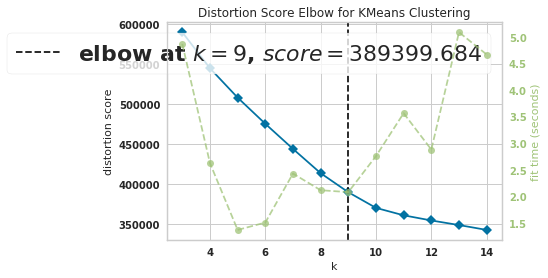

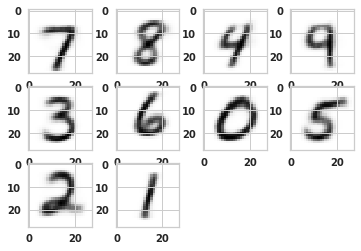

In [67]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [69]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 8, 4, 9,
                                           3, 6, 0, 5,
                                           2, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 0.9, 0.9,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


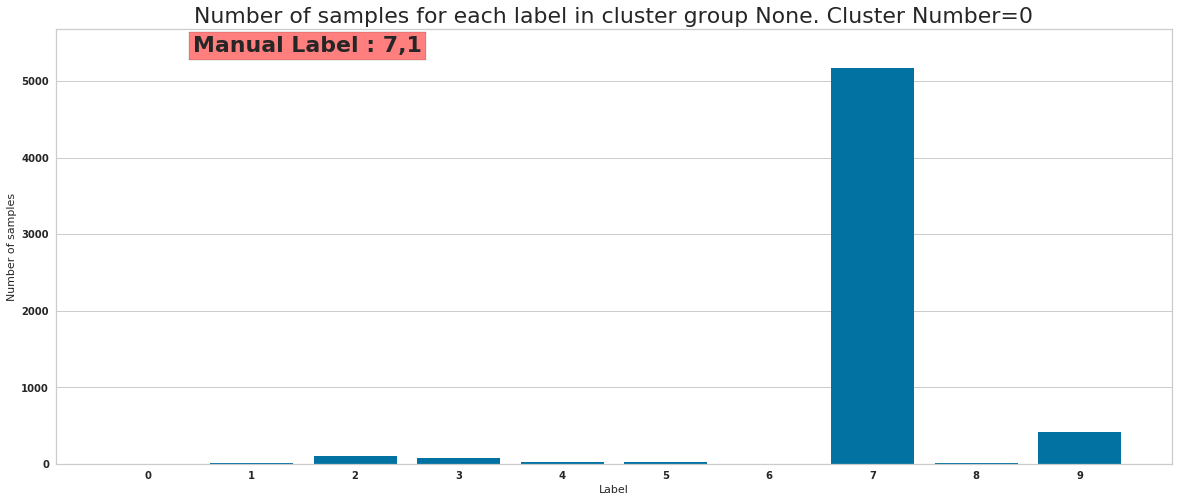

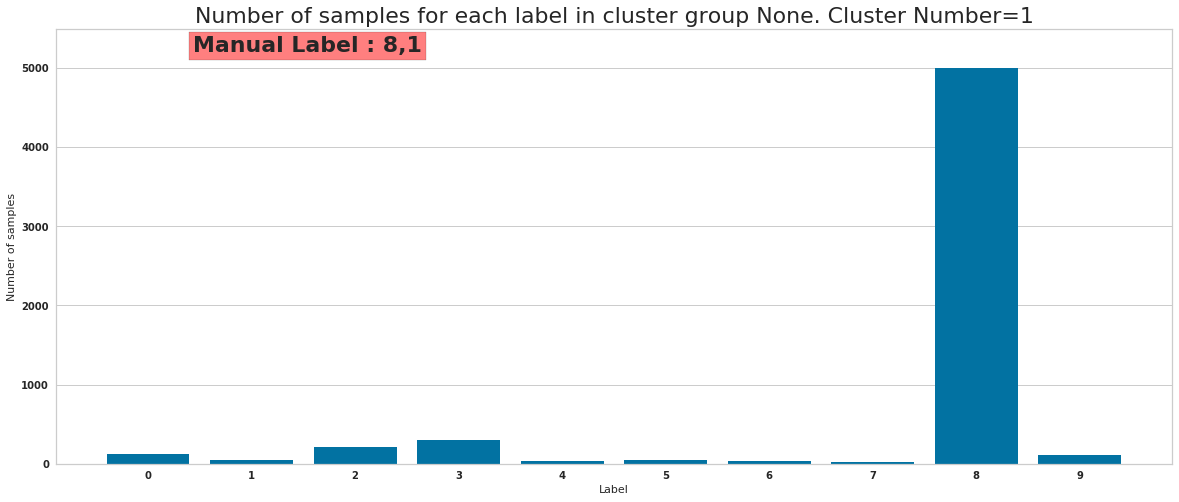

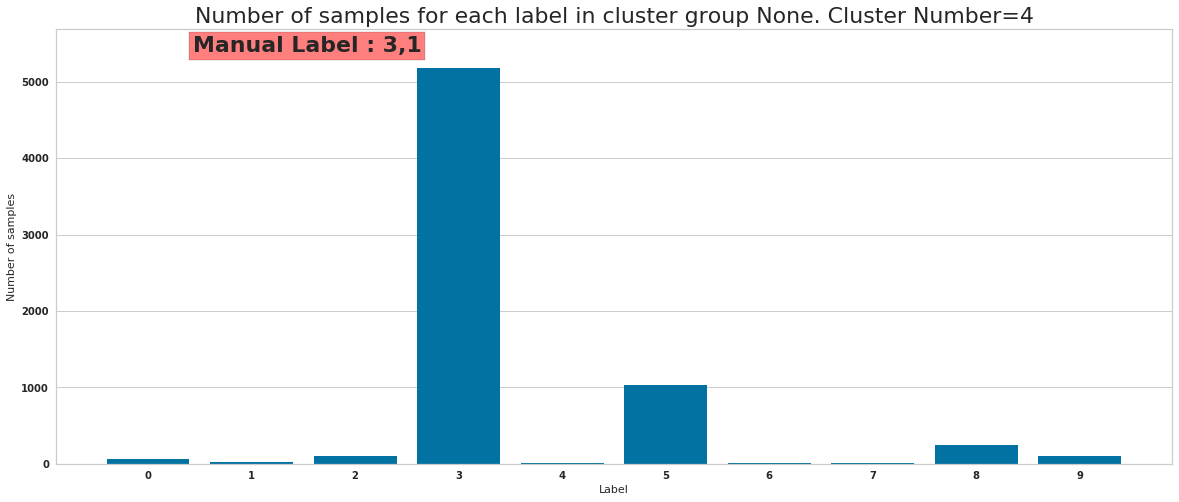

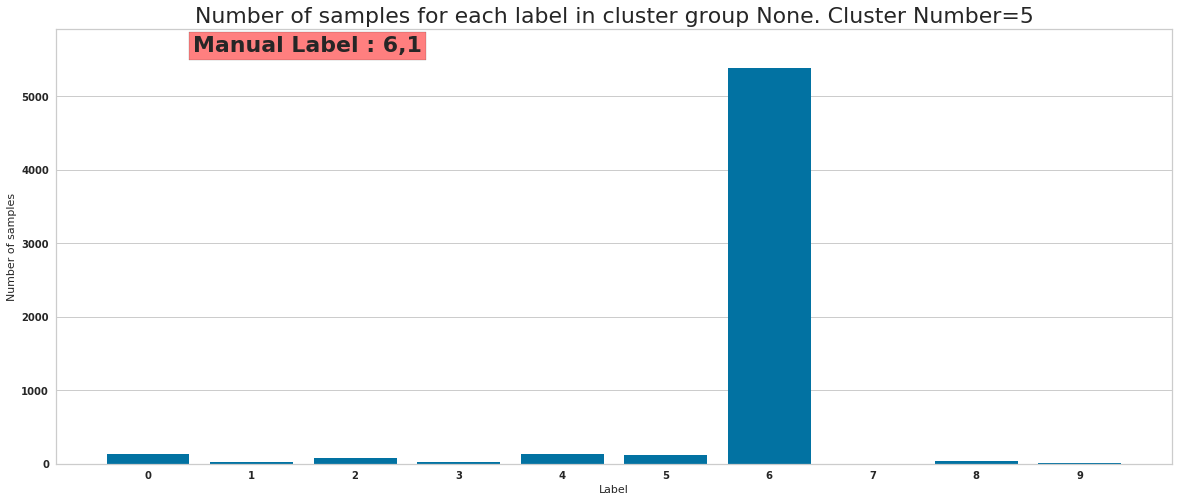

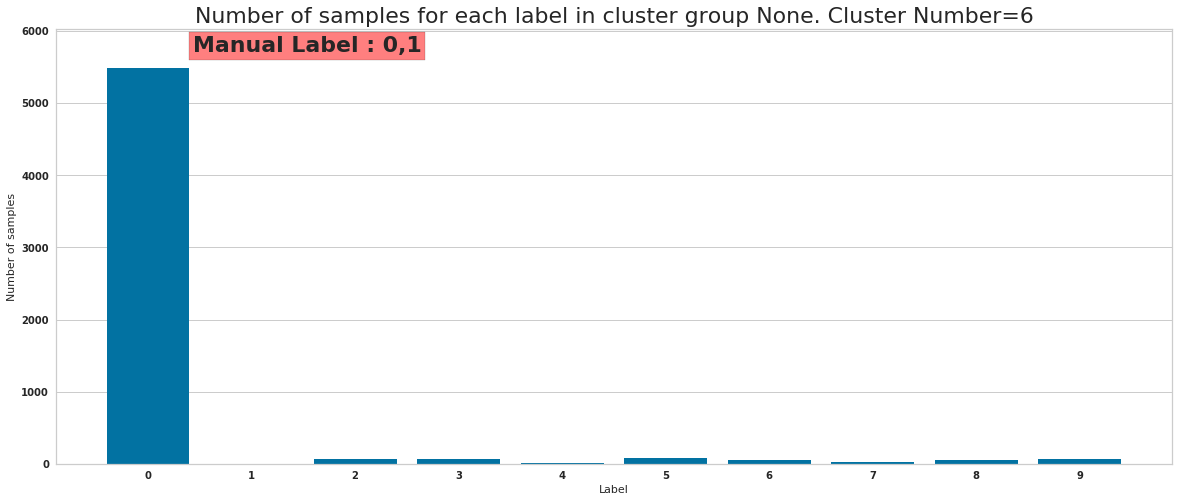

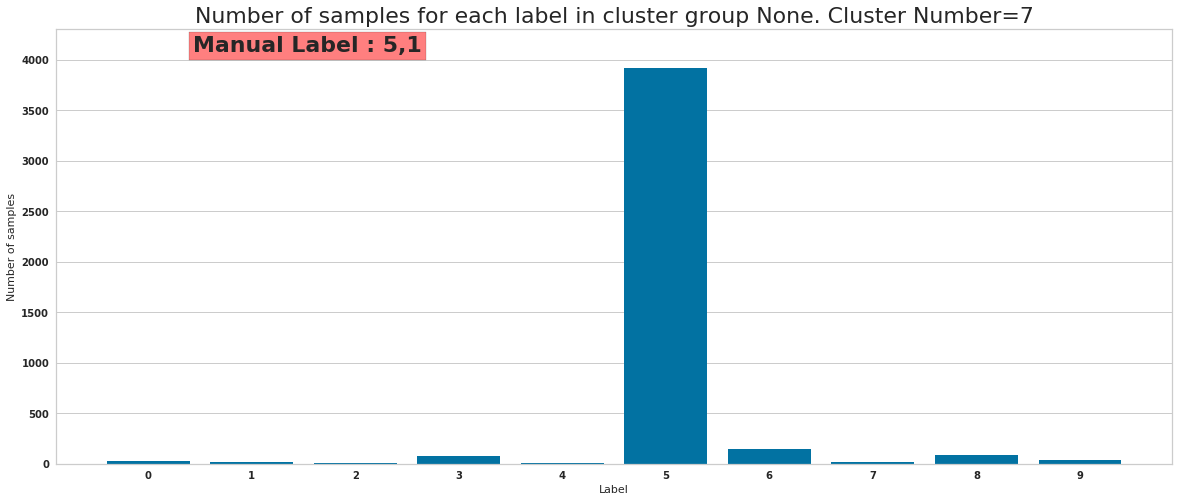

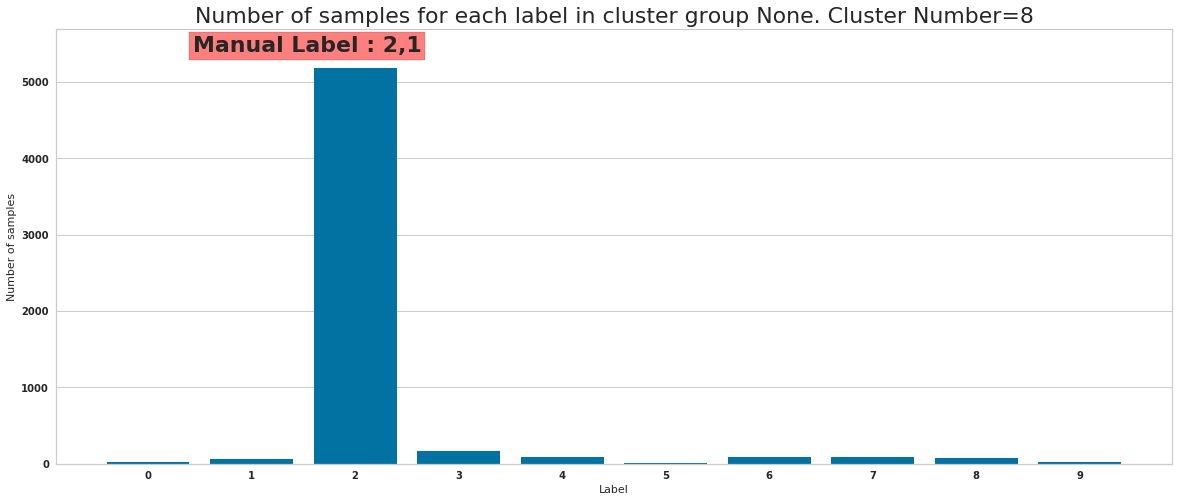

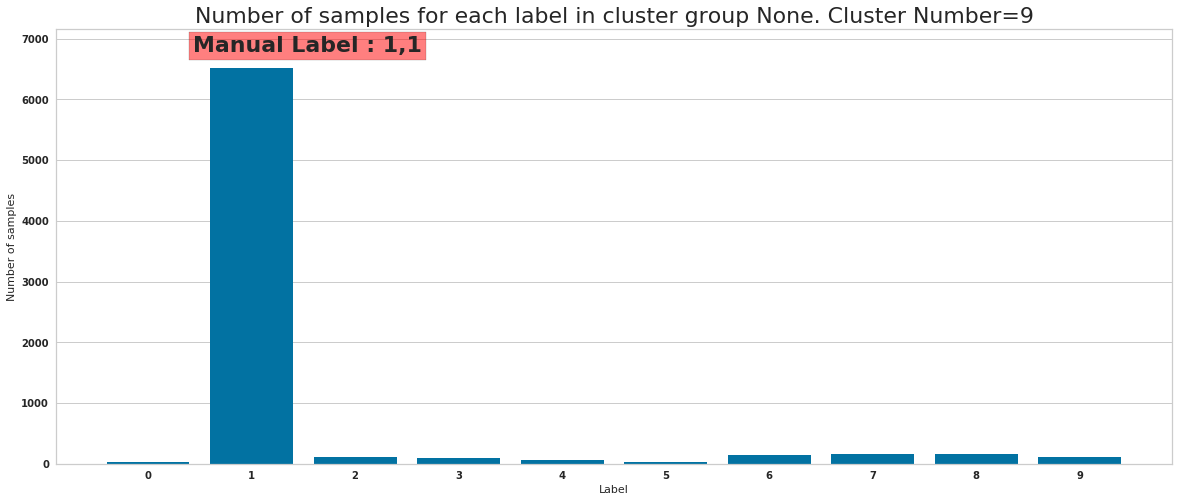

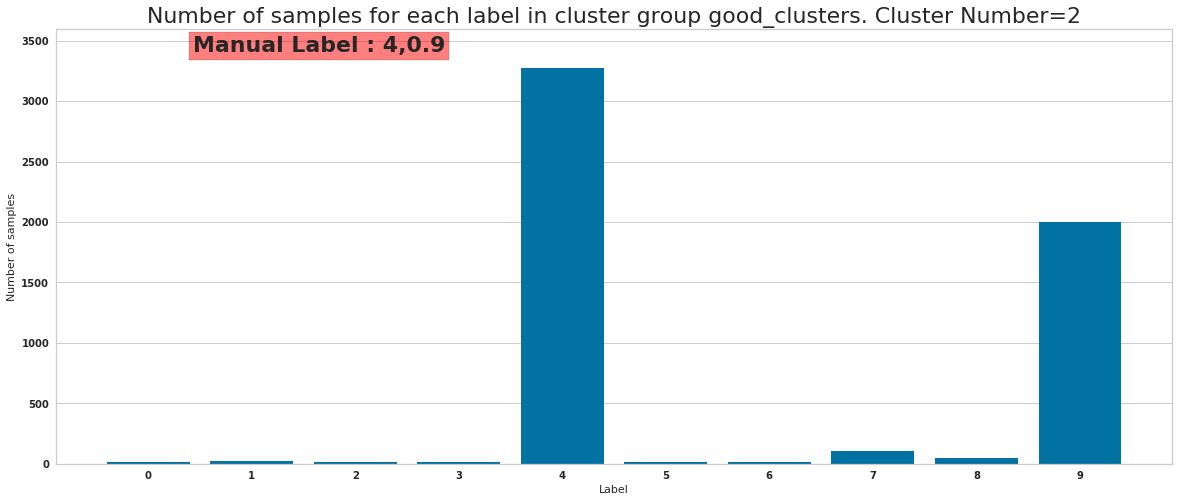

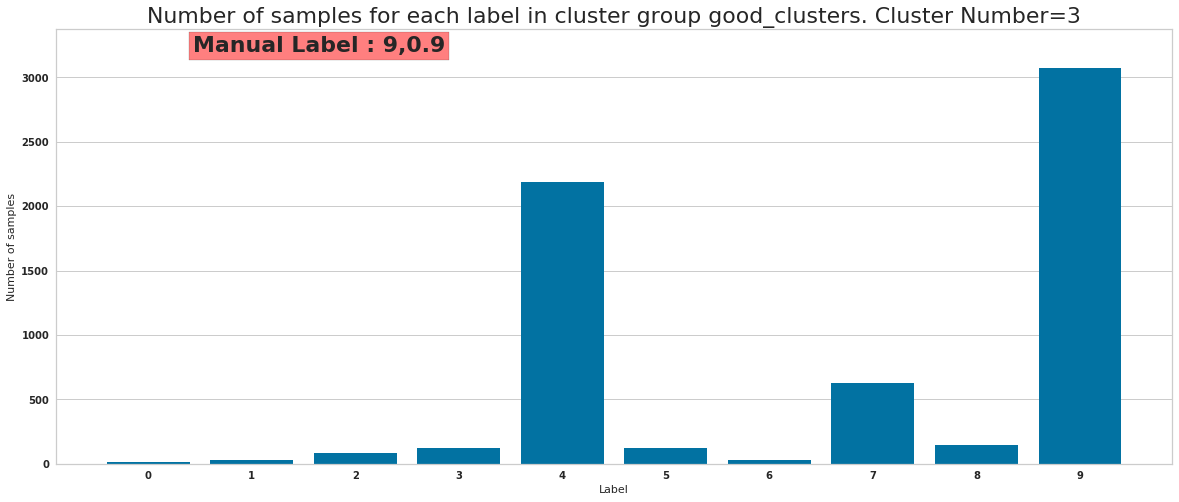

In [70]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [71]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5816, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5921, 10)
(5522, 10)
(6438, 10)
(6748, 10)
(5951, 10)
(5897, 10)
(4316, 10)
(5813, 10)
(7418, 10)


In [72]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [73]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 7
(5816, 47) (5816, 33)
Num correct=5166
Cluster 0 Manual Label 7 Percentage correct 88.82393397524072
********************************
Manual Label 8
(5921, 47) (5921, 33)
Num correct=4994
Cluster 1 Manual Label 8 Percentage correct 84.34386083431853
********************************
Manual Label 4
(5522, 47) (5522, 33)
Num correct=3270
Cluster 2 Manual Label 4 Percentage correct 59.21767475552336
********************************
Manual Label 9
(6438, 47) (6438, 33)
Num correct=3069
Cluster 3 Manual Label 9 Percentage correct 47.67008387698043
********************************
Manual Label 3
(6748, 47) (6748, 33)
Num correct=5173
Cluster 4 Manual Label 3 Percentage correct 76.65975103734439
********************************
Manual Label 6
(5951, 47) (5951, 33)
Num correct=5381
Cluster 5 Manual Label 6 Percentage correct 90.42177785246177
********************************
Manual Label 0
(5897, 47) (5897, 33)
Num correct=5482
Cluster 6 Manual Label 0 Percentage correct 92.96252

In [74]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [75]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

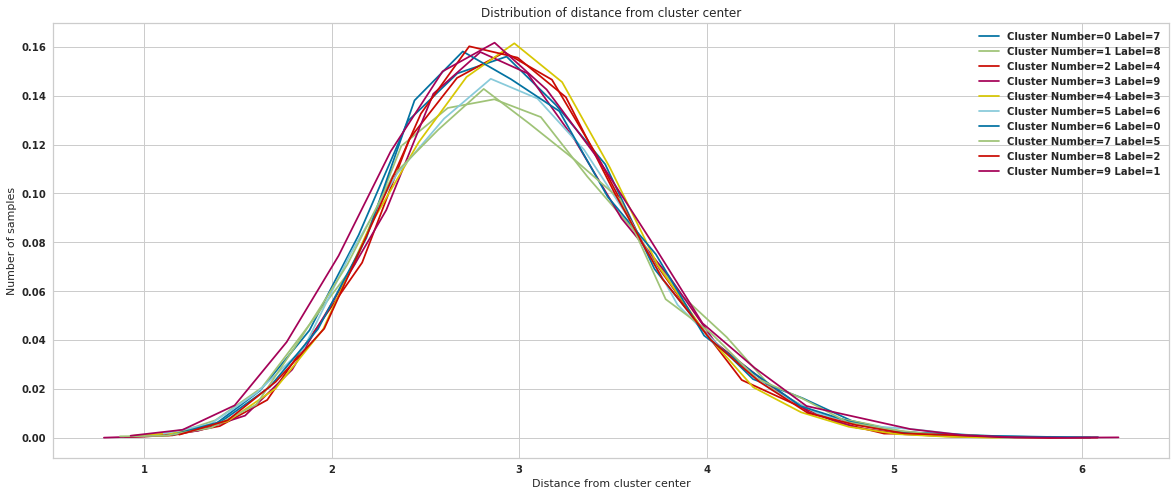

In [76]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

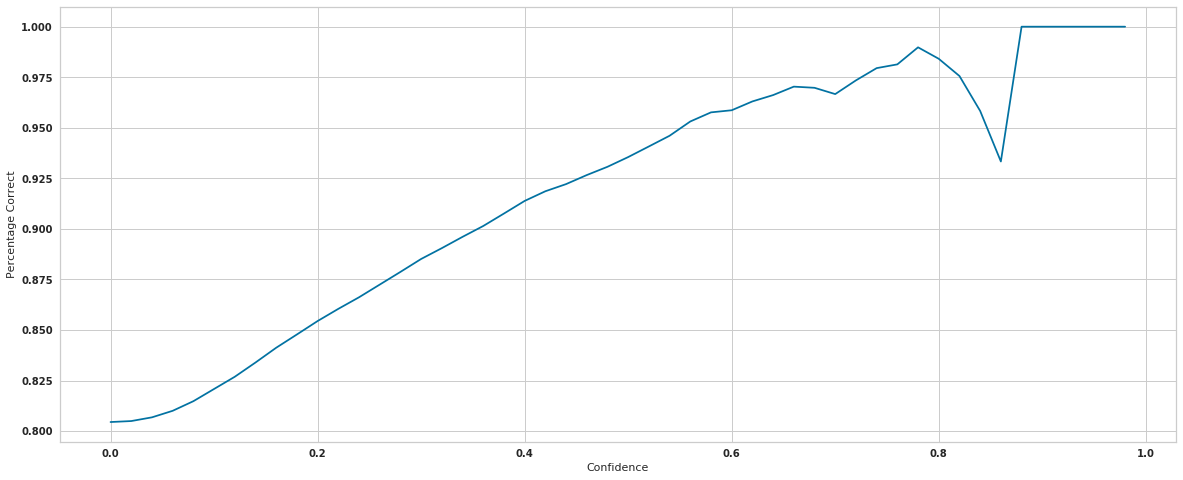

In [77]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

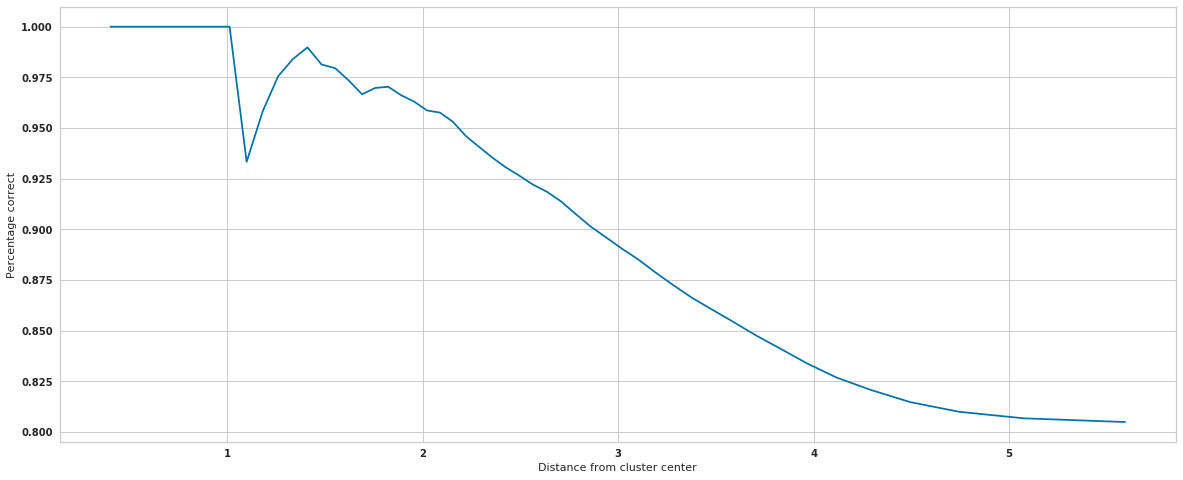

In [78]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

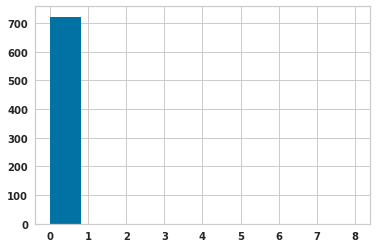

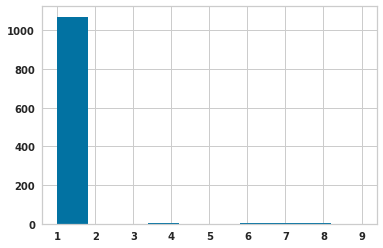

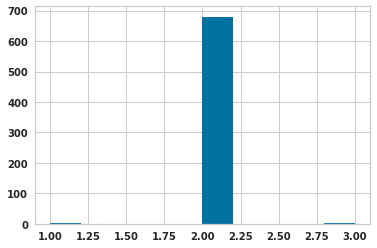

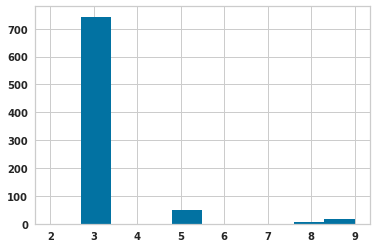

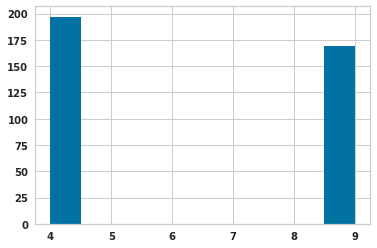

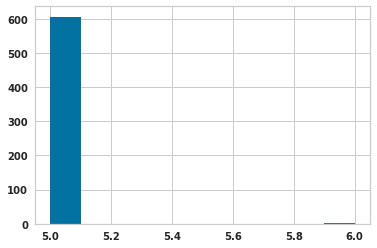

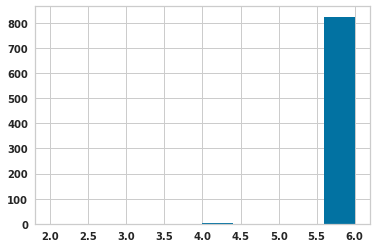

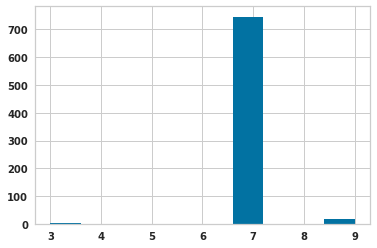

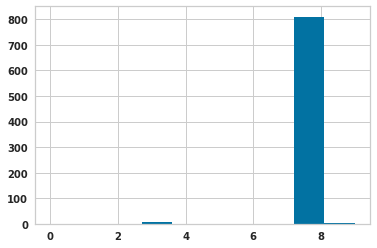

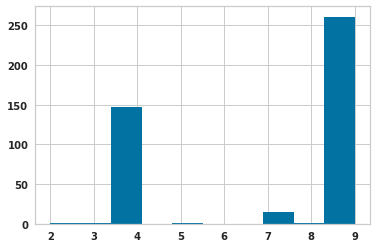

In [79]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [80]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 19031.881130598078
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 3/60, Nll_loss : 113.22715759277344 KLD:9.834589004516602  Supervised loss:0.06971022486686707
Epoch: 3/61, Nll_loss : 114.69249725341797 KLD:9.706512451171875  Supervised loss:0.10139993578195572
Epoch: 3/62, Nll_loss : 129.92413330078125 KLD:10.084901809692383  Supervised loss:0.08284880220890045
Epoch: 3/63, Nll_loss : 118.92295837402344 KLD:9.489742279052734  Supervised loss:0.08652881532907486
Epoch: 3/64, Nll_loss : 116.01889038085938 KLD:9.128327369689941  Supervised loss:0.08867224305868149
Epoch: 3/65, Nll_loss : 128.56491088867188 KLD:9.717580795288086  Supervised loss:0.10926572233438492
Epoch: 3/66, Nll_loss : 108.5865478515625 KLD:9.227853775024414  Supervised loss:0.09119941294193268
Epoch: 3/67, Nll_loss : 112.70671081542969 KLD:8.894466400146484  Supervised loss:0.11931118369102478
Epoch: 3/68, Nll_loss : 122.75566101074219 KLD:9.303306579589844  Supervised loss:0.07172847539186478
Epoch: 3/69, Nll_loss : 126.06859588623047 KLD:9.654067993164062  Supervised loss:

Epoch: 3/141, Nll_loss : 116.77011108398438 KLD:9.594136238098145  Supervised loss:0.07841265201568604
Epoch: 3/142, Nll_loss : 122.14089965820312 KLD:9.765846252441406  Supervised loss:0.06596383452415466
Epoch: 3/143, Nll_loss : 117.54615783691406 KLD:9.440622329711914  Supervised loss:0.06860369443893433
Epoch: 3/144, Nll_loss : 118.53977966308594 KLD:9.484832763671875  Supervised loss:0.07047981768846512
Epoch: 3/145, Nll_loss : 118.69222259521484 KLD:9.053707122802734  Supervised loss:0.1585385650396347
Epoch: 3/146, Nll_loss : 113.79573822021484 KLD:9.605847358703613  Supervised loss:0.07197657227516174
Epoch: 3/147, Nll_loss : 121.28268432617188 KLD:9.542661666870117  Supervised loss:0.10404641181230545
Epoch: 3/148, Nll_loss : 126.69564819335938 KLD:9.434938430786133  Supervised loss:0.10453550517559052
Epoch: 3/149, Nll_loss : 114.74232482910156 KLD:9.25859546661377  Supervised loss:0.1362842172384262
Epoch: 3/150, Nll_loss : 120.92854309082031 KLD:9.911718368530273  Supervise

Epoch: 3/222, Nll_loss : 119.50244140625 KLD:9.221474647521973  Supervised loss:0.10495540499687195
Epoch: 3/223, Nll_loss : 122.32864379882812 KLD:9.030658721923828  Supervised loss:0.14204376935958862
Epoch: 3/224, Nll_loss : 124.67181396484375 KLD:9.808976173400879  Supervised loss:0.07057462632656097
Epoch: 3/225, Nll_loss : 123.326171875 KLD:9.568153381347656  Supervised loss:0.0767669528722763
Epoch: 3/226, Nll_loss : 118.72557067871094 KLD:9.73219108581543  Supervised loss:0.08747236430644989
Epoch: 3/227, Nll_loss : 117.74179077148438 KLD:9.608952522277832  Supervised loss:0.13553354144096375
Epoch: 3/228, Nll_loss : 122.015869140625 KLD:9.806293487548828  Supervised loss:0.10924236476421356
Epoch: 3/229, Nll_loss : 114.25753021240234 KLD:9.971942901611328  Supervised loss:0.08595046401023865
Epoch: 3/230, Nll_loss : 119.1963882446289 KLD:9.674100875854492  Supervised loss:0.0991738811135292
Epoch: 3/231, Nll_loss : 120.69391632080078 KLD:10.072341918945312  Supervised loss:0.0

Epoch: 3/305, Nll_loss : 118.11038208007812 KLD:9.067051887512207  Supervised loss:0.13163867592811584
Epoch: 3/306, Nll_loss : 120.36712646484375 KLD:9.424179077148438  Supervised loss:0.09879754483699799
Epoch: 3/307, Nll_loss : 117.45036315917969 KLD:9.360574722290039  Supervised loss:0.08004960417747498
Epoch: 3/308, Nll_loss : 127.90423583984375 KLD:9.722784042358398  Supervised loss:0.09380029141902924
Epoch: 3/309, Nll_loss : 113.89727783203125 KLD:9.45177173614502  Supervised loss:0.07615789771080017
Epoch: 3/310, Nll_loss : 126.75979614257812 KLD:9.60756778717041  Supervised loss:0.11174635589122772
Epoch: 3/311, Nll_loss : 122.5465087890625 KLD:9.594444274902344  Supervised loss:0.09430274367332458
Epoch: 3/312, Nll_loss : 124.8131332397461 KLD:9.743677139282227  Supervised loss:0.07390471547842026
Epoch: 3/313, Nll_loss : 119.71586608886719 KLD:9.378244400024414  Supervised loss:0.07884480059146881
Epoch: 3/314, Nll_loss : 115.93283081054688 KLD:9.227874755859375  Supervised

Epoch: 3/385, Nll_loss : 121.57954406738281 KLD:9.237489700317383  Supervised loss:0.09080946445465088
Epoch: 3/386, Nll_loss : 125.97562408447266 KLD:9.233546257019043  Supervised loss:0.053807392716407776
Epoch: 3/387, Nll_loss : 117.7199478149414 KLD:8.679666519165039  Supervised loss:0.1108742356300354
Epoch: 3/388, Nll_loss : 120.03907775878906 KLD:8.8047456741333  Supervised loss:0.13133715093135834
Epoch: 3/389, Nll_loss : 119.39395904541016 KLD:8.880565643310547  Supervised loss:0.11152410507202148
Epoch: 3/390, Nll_loss : 123.44407653808594 KLD:9.336971282958984  Supervised loss:0.061106499284505844
Epoch: 3/391, Nll_loss : 113.07933807373047 KLD:9.276603698730469  Supervised loss:0.06389078497886658
Epoch: 3/392, Nll_loss : 117.45204162597656 KLD:9.577775001525879  Supervised loss:0.08661377429962158
Epoch: 3/393, Nll_loss : 121.78446960449219 KLD:9.811038970947266  Supervised loss:0.07389435172080994
Epoch: 3/394, Nll_loss : 116.70123291015625 KLD:9.953095436096191  Supervis

Epoch: 3/466, Nll_loss : 114.80424499511719 KLD:9.58085823059082  Supervised loss:0.1306333988904953
Epoch: 3/467, Nll_loss : 112.43539428710938 KLD:9.739030838012695  Supervised loss:0.07037585228681564
Epoch: 3/468, Nll_loss : 119.02157592773438 KLD:9.851785659790039  Supervised loss:0.069914810359478
Epoch: 3/469, Nll_loss : 112.37703704833984 KLD:9.896026611328125  Supervised loss:0.09710952639579773
Epoch: 3/470, Nll_loss : 111.1446762084961 KLD:10.073836326599121  Supervised loss:0.07606218755245209
Epoch: 3/471, Nll_loss : 116.74612426757812 KLD:9.813148498535156  Supervised loss:0.077133908867836
Epoch: 3/472, Nll_loss : 120.85964965820312 KLD:9.707856178283691  Supervised loss:0.09879074990749359
Epoch: 3/473, Nll_loss : 114.20816040039062 KLD:9.88875961303711  Supervised loss:0.08289174735546112
Epoch: 3/474, Nll_loss : 116.79126739501953 KLD:9.668272972106934  Supervised loss:0.08953717350959778
Epoch: 3/475, Nll_loss : 121.08221435546875 KLD:9.417095184326172  Supervised lo

Epoch: 3/547, Nll_loss : 122.91344451904297 KLD:9.108840942382812  Supervised loss:0.08892913162708282
Epoch: 3/548, Nll_loss : 114.49043273925781 KLD:8.974588394165039  Supervised loss:0.11940693855285645
Epoch: 3/549, Nll_loss : 114.79305267333984 KLD:9.047247886657715  Supervised loss:0.0863347053527832
Epoch: 3/550, Nll_loss : 115.27232360839844 KLD:9.193670272827148  Supervised loss:0.07944842427968979
Epoch: 3/551, Nll_loss : 121.2697525024414 KLD:9.256698608398438  Supervised loss:0.09710504859685898
Epoch: 3/552, Nll_loss : 112.28291320800781 KLD:9.110101699829102  Supervised loss:0.08679627627134323
Epoch: 3/553, Nll_loss : 121.35385131835938 KLD:9.530679702758789  Supervised loss:0.0814620703458786
Epoch: 3/554, Nll_loss : 118.43572998046875 KLD:9.643158912658691  Supervised loss:0.0692470371723175
Epoch: 3/555, Nll_loss : 118.37004852294922 KLD:10.123629570007324  Supervised loss:0.12239928543567657
Epoch: 3/556, Nll_loss : 120.46199035644531 KLD:10.085384368896484  Supervis

Epoch: 3/629, Nll_loss : 120.42646789550781 KLD:9.314159393310547  Supervised loss:0.08813762664794922
Epoch: 3/630, Nll_loss : 120.72269439697266 KLD:9.373208045959473  Supervised loss:0.08736224472522736
Epoch: 3/631, Nll_loss : 113.916015625 KLD:9.188369750976562  Supervised loss:0.09858729690313339
Epoch: 3/632, Nll_loss : 113.10987854003906 KLD:9.4170503616333  Supervised loss:0.06898574531078339
Epoch: 3/633, Nll_loss : 113.43600463867188 KLD:9.425039291381836  Supervised loss:0.07698357105255127
Epoch: 3/634, Nll_loss : 114.93470001220703 KLD:9.384223937988281  Supervised loss:0.12944766879081726
Epoch: 3/635, Nll_loss : 115.60835266113281 KLD:9.630988121032715  Supervised loss:0.1154215931892395
Epoch: 3/636, Nll_loss : 116.5249252319336 KLD:9.78181266784668  Supervised loss:0.13059434294700623
Epoch: 3/637, Nll_loss : 111.32691955566406 KLD:9.354933738708496  Supervised loss:0.04805048927664757
Epoch: 3/638, Nll_loss : 116.29866027832031 KLD:9.497055053710938  Supervised loss:

Epoch: 3/710, Nll_loss : 118.61181640625 KLD:9.09743881225586  Supervised loss:0.06898576766252518
Epoch: 3/711, Nll_loss : 116.50869750976562 KLD:8.97383975982666  Supervised loss:0.10526295006275177
Epoch: 3/712, Nll_loss : 123.29908752441406 KLD:9.179943084716797  Supervised loss:0.09536349028348923
Epoch: 3/713, Nll_loss : 115.71131896972656 KLD:9.19487190246582  Supervised loss:0.10641926527023315
Epoch: 3/714, Nll_loss : 114.25404357910156 KLD:9.5978364944458  Supervised loss:0.05217116326093674
Epoch: 3/715, Nll_loss : 114.52688598632812 KLD:9.37656021118164  Supervised loss:0.08026481419801712
Epoch: 3/716, Nll_loss : 108.35812377929688 KLD:9.562286376953125  Supervised loss:0.06464377045631409
Epoch: 3/717, Nll_loss : 120.37384033203125 KLD:10.130763053894043  Supervised loss:0.05087561160326004
Epoch: 3/718, Nll_loss : 109.21923828125 KLD:9.625659942626953  Supervised loss:0.08164901286363602
Epoch: 3/719, Nll_loss : 119.27689361572266 KLD:9.355412483215332  Supervised loss:0

Epoch: 3/791, Nll_loss : 112.51103210449219 KLD:9.139924049377441  Supervised loss:0.11185163259506226
Epoch: 3/792, Nll_loss : 121.46478271484375 KLD:9.425322532653809  Supervised loss:0.05975944921374321
Epoch: 3/793, Nll_loss : 111.6502685546875 KLD:9.128646850585938  Supervised loss:0.06504093110561371
Epoch: 3/794, Nll_loss : 118.70379638671875 KLD:9.75753402709961  Supervised loss:0.04868534579873085
Epoch: 3/795, Nll_loss : 119.16426086425781 KLD:9.422014236450195  Supervised loss:0.11198535561561584
Epoch: 3/796, Nll_loss : 123.86288452148438 KLD:9.891044616699219  Supervised loss:0.06483729928731918
Epoch: 3/797, Nll_loss : 114.27253723144531 KLD:9.794319152832031  Supervised loss:0.12754018604755402
Epoch: 3/798, Nll_loss : 115.08466339111328 KLD:9.281084060668945  Supervised loss:0.14649353921413422
Epoch: 3/799, Nll_loss : 127.4404296875 KLD:9.704194068908691  Supervised loss:0.09654983878135681
Epoch: 3/800, Nll_loss : 122.67755889892578 KLD:9.605765342712402  Supervised l

Epoch: 3/872, Nll_loss : 116.7064208984375 KLD:9.031975746154785  Supervised loss:0.09808067977428436
Epoch: 3/873, Nll_loss : 119.13160705566406 KLD:9.121307373046875  Supervised loss:0.08102686703205109
Epoch: 3/874, Nll_loss : 119.1125259399414 KLD:9.091289520263672  Supervised loss:0.08371630311012268
Epoch: 3/875, Nll_loss : 121.1302490234375 KLD:8.8802490234375  Supervised loss:0.07945317029953003
Epoch: 3/876, Nll_loss : 117.4754638671875 KLD:8.896449089050293  Supervised loss:0.10422728210687637
Epoch: 3/877, Nll_loss : 123.2637939453125 KLD:9.386883735656738  Supervised loss:0.09348428249359131
Epoch: 3/878, Nll_loss : 124.42444610595703 KLD:9.709102630615234  Supervised loss:0.07005054503679276
Epoch: 3/879, Nll_loss : 110.1668701171875 KLD:9.735824584960938  Supervised loss:0.04858092963695526
Epoch: 3/880, Nll_loss : 111.08183288574219 KLD:9.747459411621094  Supervised loss:0.11084000766277313
Epoch: 3/881, Nll_loss : 115.30558013916016 KLD:10.217529296875  Supervised loss:

In [81]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

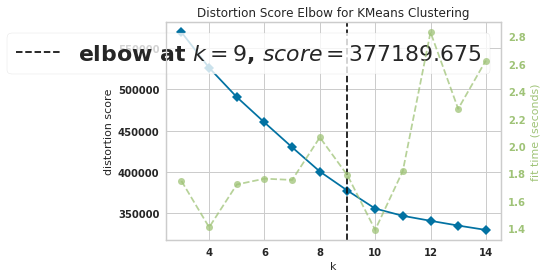

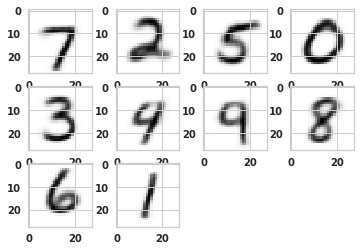

In [82]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [83]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 2, 5, 0,
                                           3, -1, 9, 8,
                                           6, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 0, 0.8, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


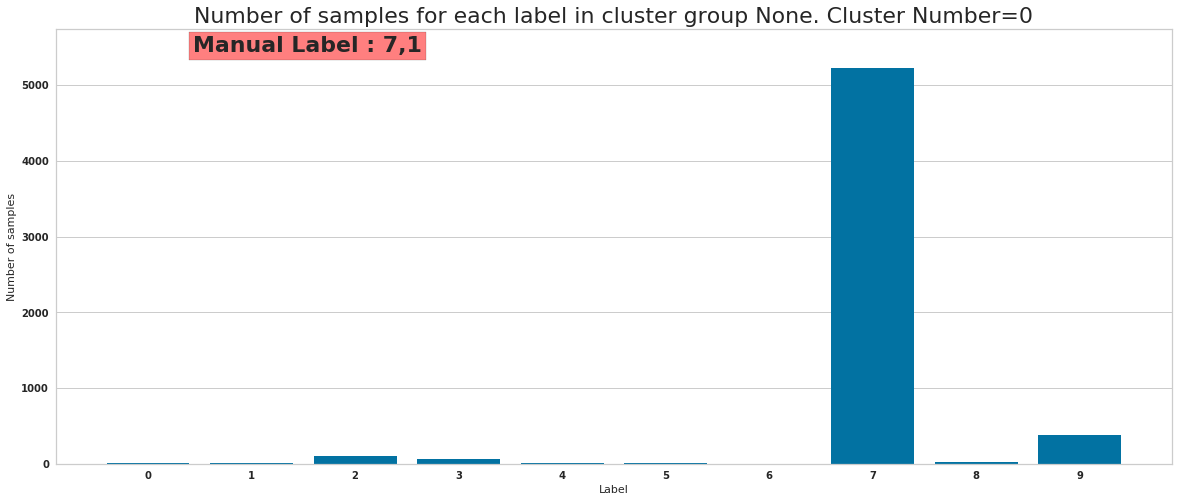

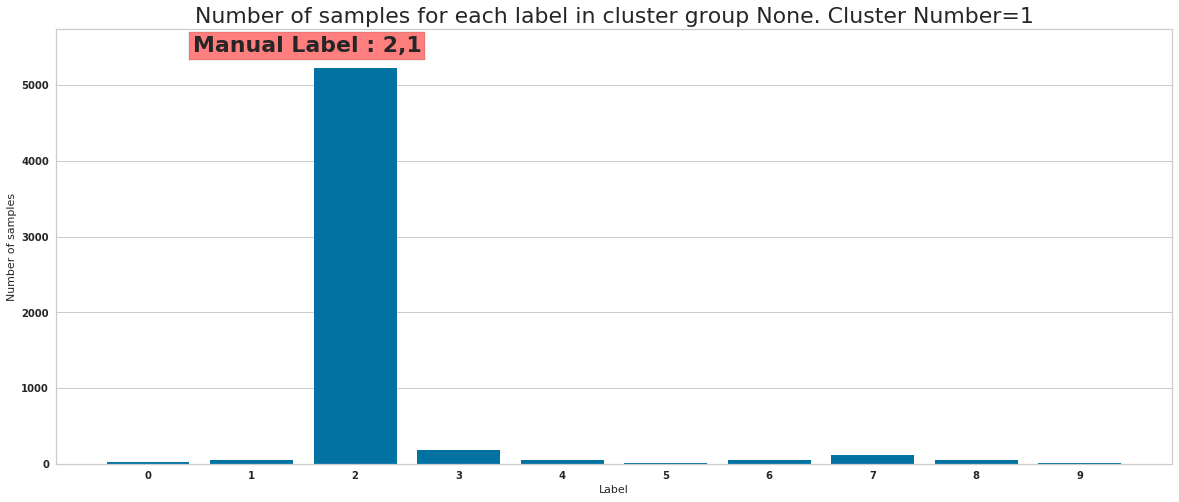

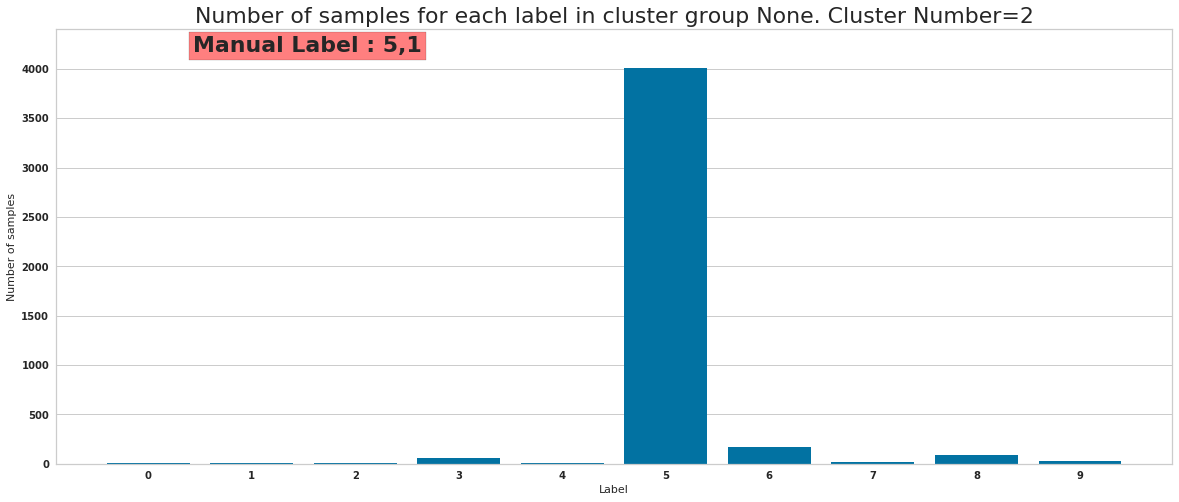

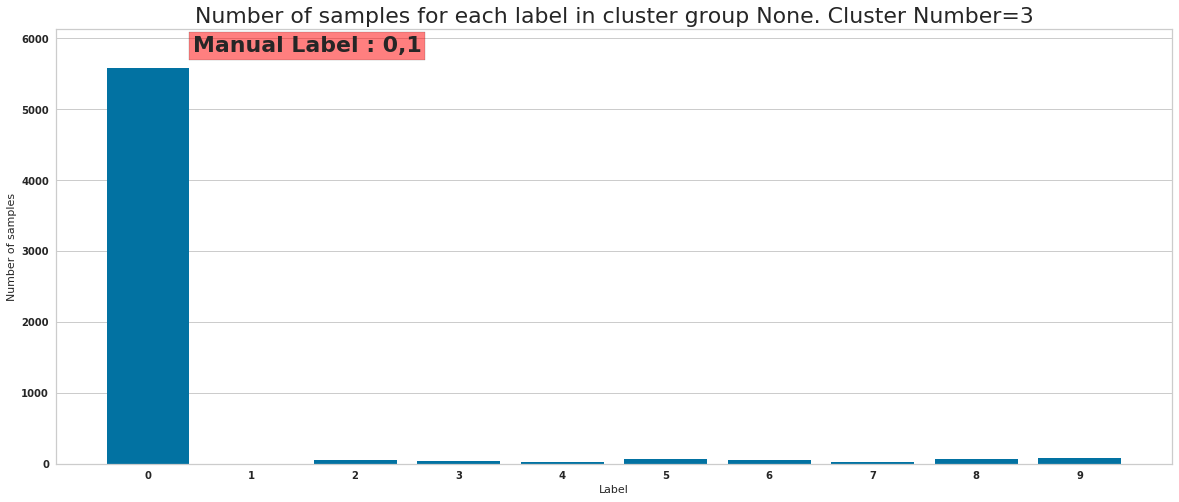

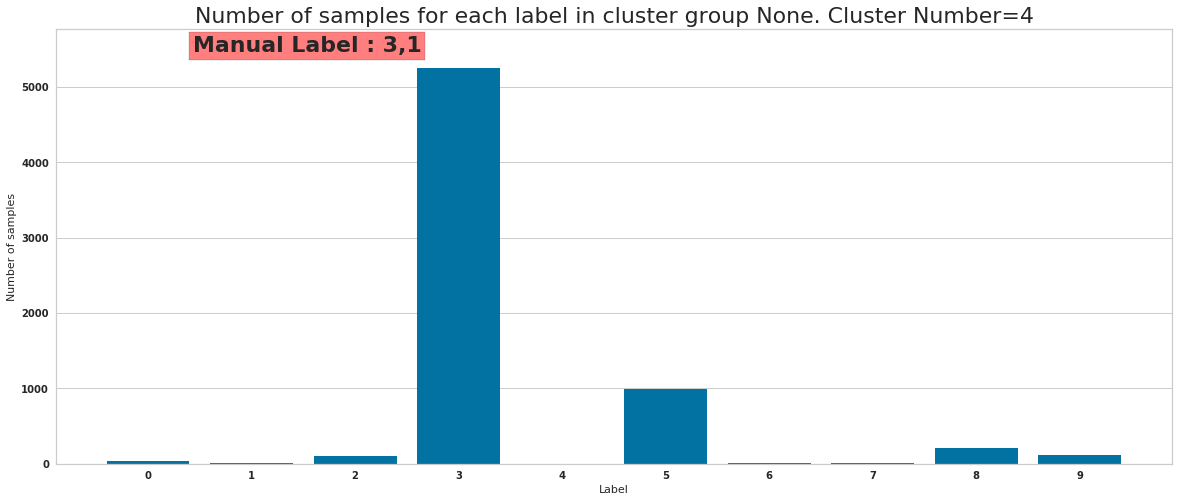

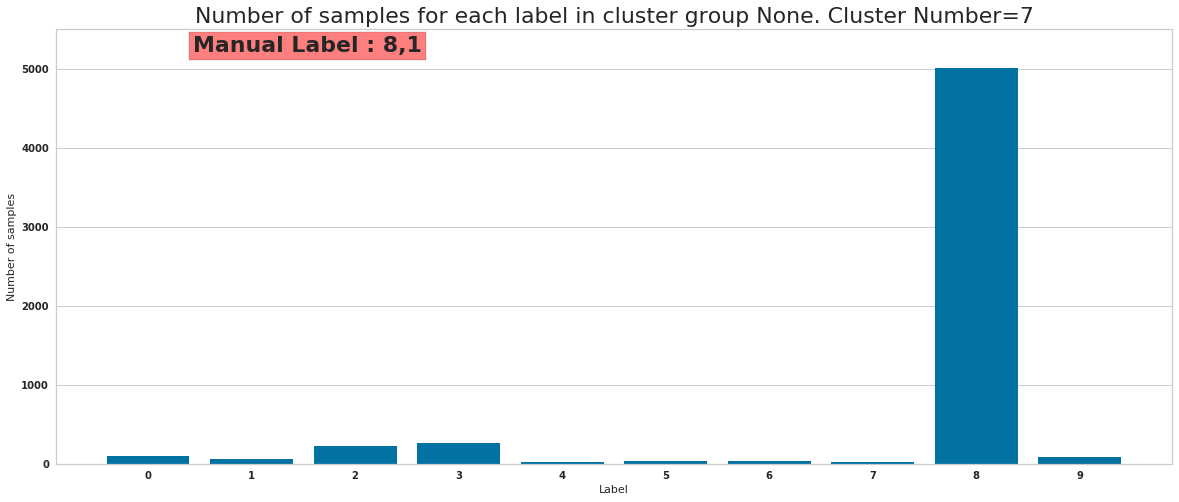

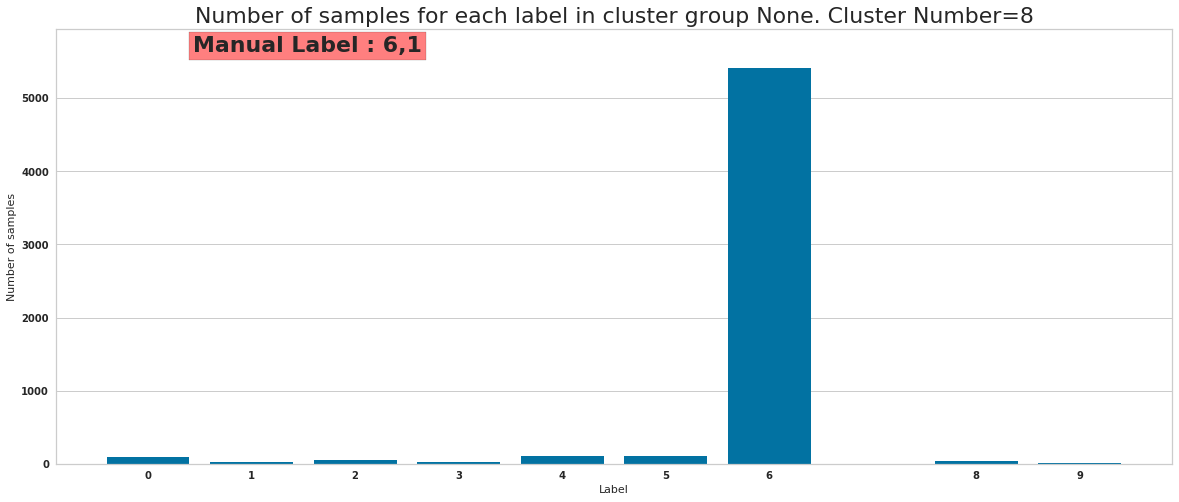

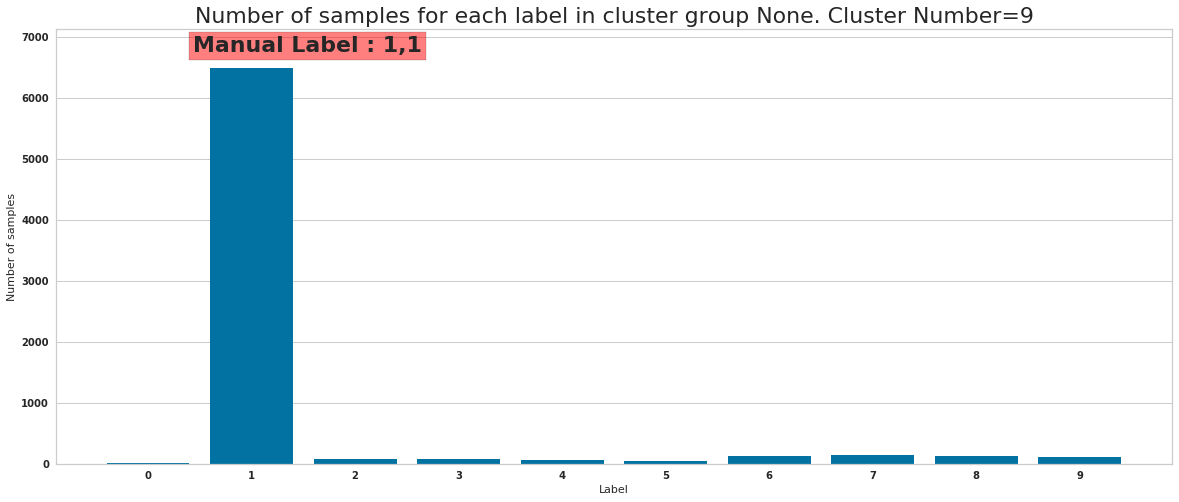

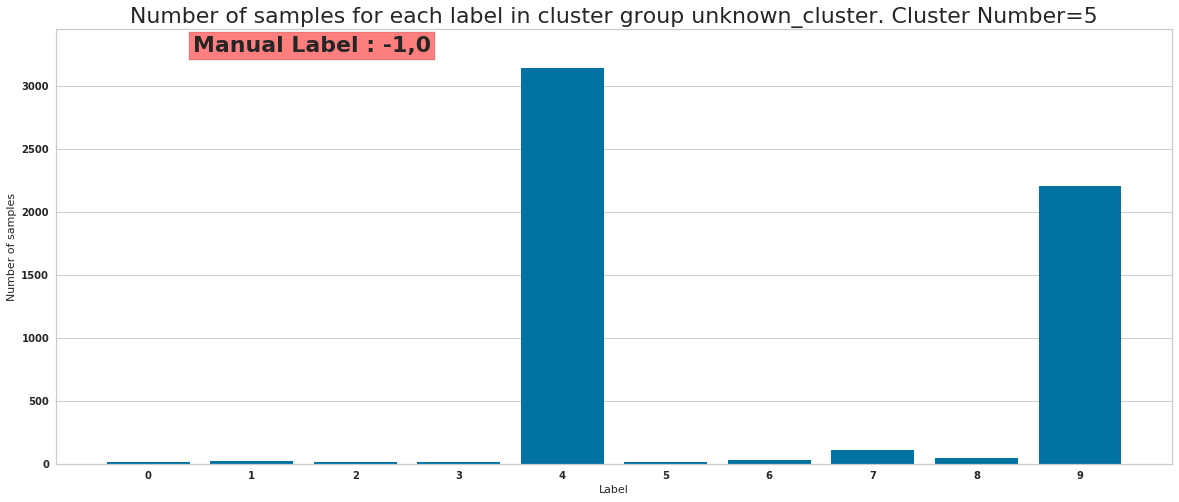

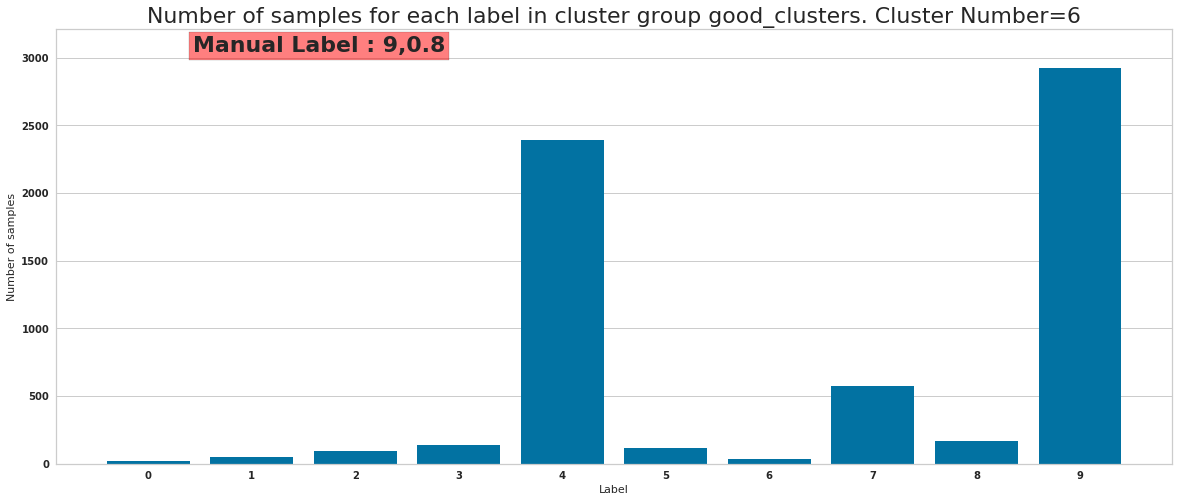

In [84]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

(5840, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5781, 10)
(4399, 10)
(5986, 10)
(6738, 10)
(5625, 10)
(6504, 10)
(5851, 10)
(5865, 10)
(7251, 10)
5
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Re

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


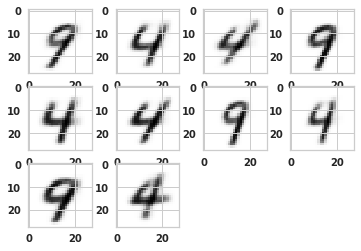

In [85]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [86]:
# level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [9, 4, 4, 9,
                                         4, 4, 9, 4,
                                         9, 4
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.8,0.8,
                                             0.8,0.8,0.8,0.8,
                                             0.8,0.8]
level2_manual_annotations[5] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [87]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

5
10
0 (691,)
1 (548,)
2 (574,)
3 (660,)
4 (460,)
5 (552,)
6 (686,)
7 (509,)
8 (516,)
9 (429,)
Manual Label 7
(5840, 57) (5840, 33)
Num correct=5219
Cluster 0 Manual Label 7 Percentage correct 89.36643835616438
********************************
Manual Label 2
(5781, 57) (5781, 33)
Num correct=5218
Cluster 1 Manual Label 2 Percentage correct 90.26120048434527
********************************
Manual Label 5
(4399, 57) (4399, 33)
Num correct=4003
Cluster 2 Manual Label 5 Percentage correct 90.99795408047284
********************************
Manual Label 0
(5986, 57) (5986, 33)
Num correct=5577
Cluster 3 Manual Label 0 Percentage correct 93.16739057801537
********************************
Manual Label 3
(6738, 57) (6738, 33)
Num correct=5245
Cluster 4 Manual Label 3 Percentage correct 77.84208964084299
********************************
unknown
<class 'dict'>
['good_clusters']
********9*******
Manual_label 9
********4*******
Manual_label 4
********4*******
Manual_label 4
********9*******
Manual

In [88]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

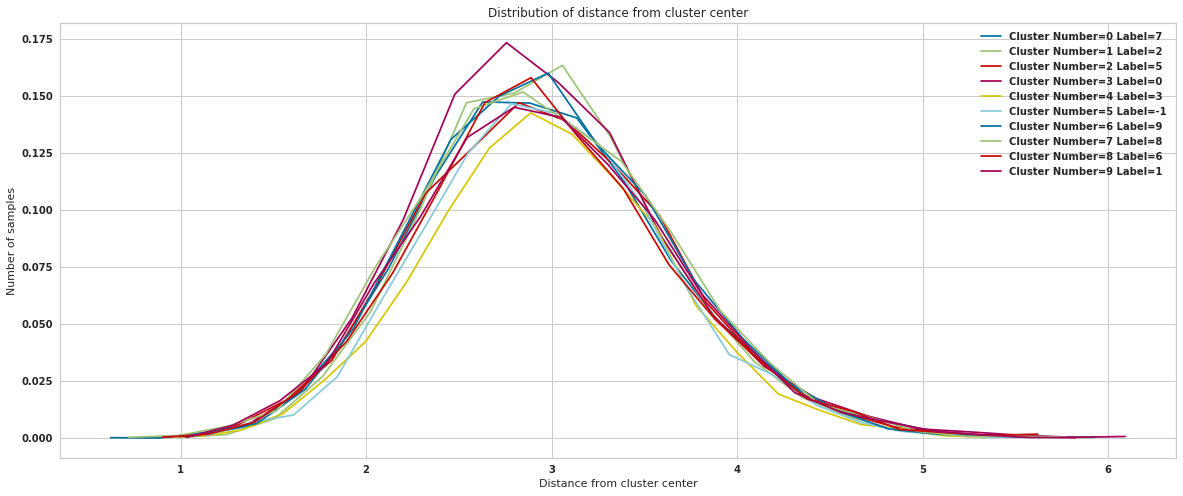

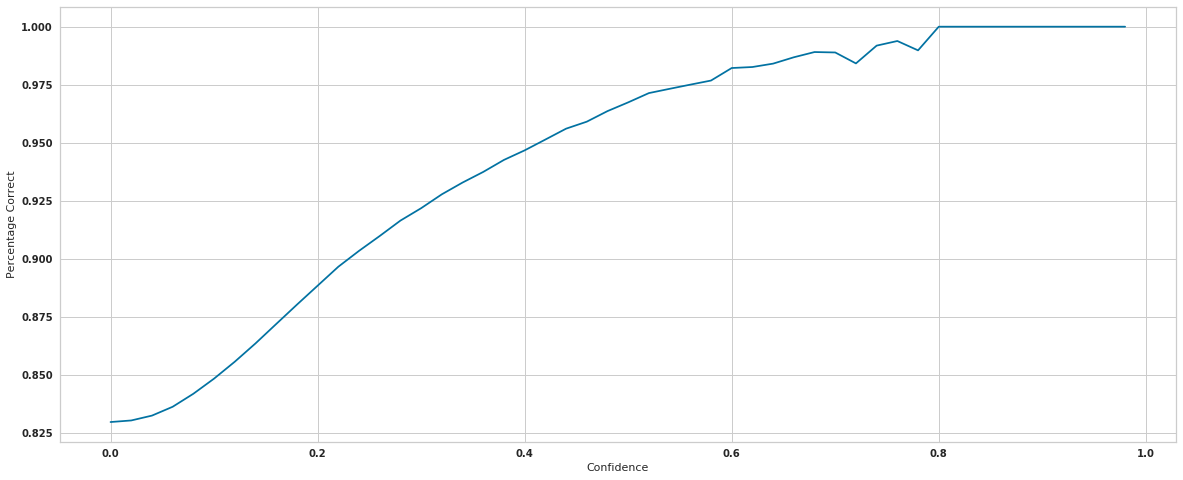

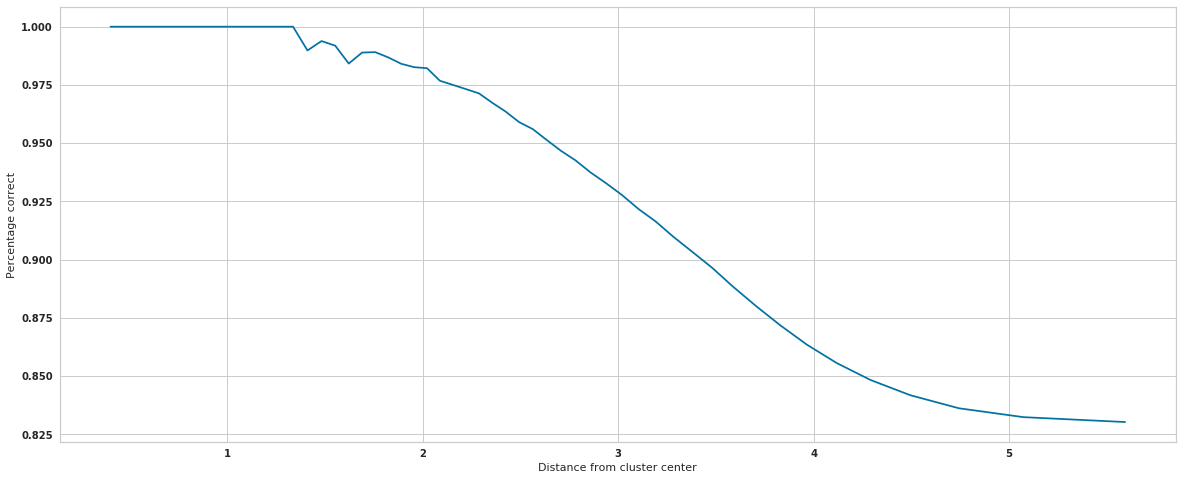

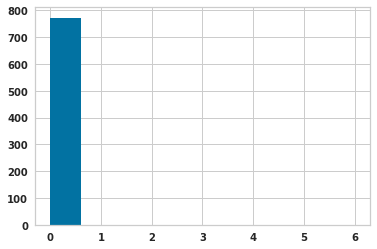

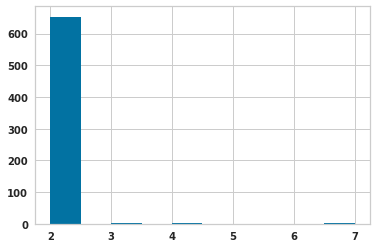

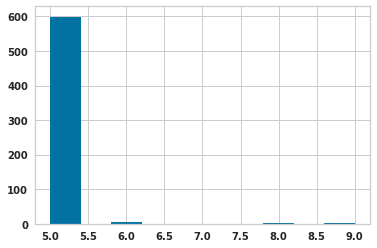

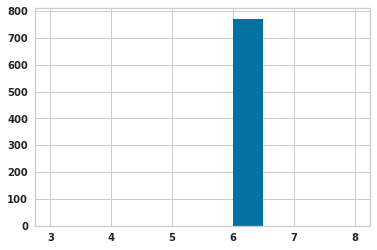

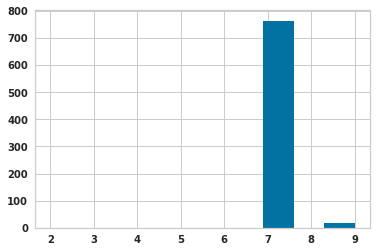

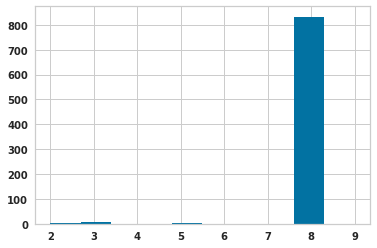

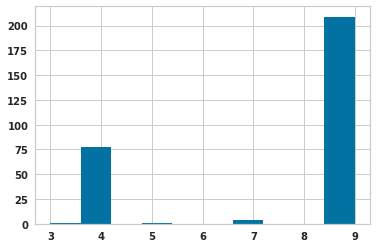

In [89]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [90]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 18640.44296649598
INFO:tensorflow:Summary name Negative Log Likeli

Epoch: 4/61, Nll_loss : 116.03243255615234 KLD:9.39434814453125  Supervised loss:0.0880088210105896
Epoch: 4/62, Nll_loss : 125.99564361572266 KLD:10.086771011352539  Supervised loss:0.09246321022510529
Epoch: 4/63, Nll_loss : 120.52699279785156 KLD:9.510750770568848  Supervised loss:0.07197773456573486
Epoch: 4/64, Nll_loss : 119.05384826660156 KLD:9.158361434936523  Supervised loss:0.08770160377025604
Epoch: 4/65, Nll_loss : 121.60769653320312 KLD:9.757333755493164  Supervised loss:0.11345124989748001
Epoch: 4/66, Nll_loss : 109.48069763183594 KLD:9.029475212097168  Supervised loss:0.08547156304121017
Epoch: 4/67, Nll_loss : 110.24800109863281 KLD:8.82116413116455  Supervised loss:0.10101635009050369
Epoch: 4/68, Nll_loss : 119.78010559082031 KLD:9.104098320007324  Supervised loss:0.0874488353729248
Epoch: 4/69, Nll_loss : 123.90458679199219 KLD:9.448867797851562  Supervised loss:0.0895434021949768
Epoch: 4/70, Nll_loss : 117.99512481689453 KLD:9.334760665893555  Supervised loss:0.09

Epoch: 4/142, Nll_loss : 120.82797241210938 KLD:9.376729965209961  Supervised loss:0.09341754019260406
Epoch: 4/143, Nll_loss : 117.69561767578125 KLD:9.178961753845215  Supervised loss:0.09377024322748184
Epoch: 4/144, Nll_loss : 113.7956314086914 KLD:9.135287284851074  Supervised loss:0.07165743410587311
Epoch: 4/145, Nll_loss : 121.68213653564453 KLD:8.834085464477539  Supervised loss:0.09691531211137772
Epoch: 4/146, Nll_loss : 111.28340911865234 KLD:9.55392074584961  Supervised loss:0.05699051916599274
Epoch: 4/147, Nll_loss : 118.17478942871094 KLD:9.77178955078125  Supervised loss:0.08069955557584763
Epoch: 4/148, Nll_loss : 121.34072875976562 KLD:9.781005859375  Supervised loss:0.10859794914722443
Epoch: 4/149, Nll_loss : 112.81061553955078 KLD:9.686620712280273  Supervised loss:0.11521699279546738
Epoch: 4/150, Nll_loss : 119.88835906982422 KLD:10.143672943115234  Supervised loss:0.08259286731481552
Epoch: 4/151, Nll_loss : 114.42588806152344 KLD:9.831430435180664  Supervised 

Epoch: 4/222, Nll_loss : 119.54918670654297 KLD:9.744401931762695  Supervised loss:0.08229365199804306
Epoch: 4/223, Nll_loss : 117.7297592163086 KLD:9.446744918823242  Supervised loss:0.05570867285132408
Epoch: 4/224, Nll_loss : 120.08901977539062 KLD:10.0005464553833  Supervised loss:0.058252837508916855
Epoch: 4/225, Nll_loss : 125.03546142578125 KLD:9.52972412109375  Supervised loss:0.11950995773077011
Epoch: 4/226, Nll_loss : 115.63789367675781 KLD:9.440727233886719  Supervised loss:0.06842292845249176
Epoch: 4/227, Nll_loss : 115.96245574951172 KLD:9.271709442138672  Supervised loss:0.16041770577430725
Epoch: 4/228, Nll_loss : 120.91835021972656 KLD:9.374188423156738  Supervised loss:0.06906937807798386
Epoch: 4/229, Nll_loss : 116.01826477050781 KLD:9.618244171142578  Supervised loss:0.08090279996395111
Epoch: 4/230, Nll_loss : 123.44964599609375 KLD:9.383102416992188  Supervised loss:0.09418158233165741
Epoch: 4/231, Nll_loss : 117.71552276611328 KLD:9.816582679748535  Supervis

Epoch: 4/303, Nll_loss : 114.98712921142578 KLD:9.71516227722168  Supervised loss:0.06321626901626587
Epoch: 4/304, Nll_loss : 116.69579315185547 KLD:9.763345718383789  Supervised loss:0.07703395187854767
Epoch: 4/305, Nll_loss : 108.8524169921875 KLD:9.537773132324219  Supervised loss:0.0894814133644104
Epoch: 4/306, Nll_loss : 121.43809509277344 KLD:9.692464828491211  Supervised loss:0.15081439912319183
Epoch: 4/307, Nll_loss : 115.17703247070312 KLD:9.504627227783203  Supervised loss:0.051551703363657
Epoch: 4/308, Nll_loss : 123.90641021728516 KLD:9.664077758789062  Supervised loss:0.08905291557312012
Epoch: 4/309, Nll_loss : 117.85504150390625 KLD:9.181909561157227  Supervised loss:0.11286167055368423
Epoch: 4/310, Nll_loss : 124.13931274414062 KLD:9.317217826843262  Supervised loss:0.08400771021842957
Epoch: 4/311, Nll_loss : 126.03034210205078 KLD:9.219598770141602  Supervised loss:0.07952938228845596
Epoch: 4/312, Nll_loss : 122.84600830078125 KLD:9.328054428100586  Supervised 

Epoch: 4/383, Nll_loss : 121.08277130126953 KLD:9.200628280639648  Supervised loss:0.09000982344150543
Epoch: 4/384, Nll_loss : 127.49292755126953 KLD:9.946073532104492  Supervised loss:0.06968802213668823
Epoch: 4/385, Nll_loss : 117.66667938232422 KLD:9.992928504943848  Supervised loss:0.09723088145256042
Epoch: 4/386, Nll_loss : 116.85614776611328 KLD:10.128616333007812  Supervised loss:0.04186781495809555
Epoch: 4/387, Nll_loss : 112.3829116821289 KLD:9.612011909484863  Supervised loss:0.09927906841039658
Epoch: 4/388, Nll_loss : 116.29185485839844 KLD:9.67753791809082  Supervised loss:0.09559787064790726
Epoch: 4/389, Nll_loss : 116.99394226074219 KLD:9.449980735778809  Supervised loss:0.10157858580350876
Epoch: 4/390, Nll_loss : 117.23703002929688 KLD:9.794151306152344  Supervised loss:0.09565522521734238
Epoch: 4/391, Nll_loss : 115.1553955078125 KLD:9.433629989624023  Supervised loss:0.07519340515136719
Epoch: 4/392, Nll_loss : 113.1383056640625 KLD:9.644126892089844  Supervise

Epoch: 4/465, Nll_loss : 124.98294067382812 KLD:9.073308944702148  Supervised loss:0.11987349390983582
Epoch: 4/466, Nll_loss : 116.16517639160156 KLD:9.027600288391113  Supervised loss:0.06856942176818848
Epoch: 4/467, Nll_loss : 111.58668518066406 KLD:9.229328155517578  Supervised loss:0.07006387412548065
Epoch: 4/468, Nll_loss : 119.28585052490234 KLD:9.371082305908203  Supervised loss:0.09857474267482758
Epoch: 4/469, Nll_loss : 112.52145385742188 KLD:9.541727066040039  Supervised loss:0.08736374229192734
Epoch: 4/470, Nll_loss : 111.79871368408203 KLD:9.848485946655273  Supervised loss:0.057668592780828476
Epoch: 4/471, Nll_loss : 114.28575134277344 KLD:9.789163589477539  Supervised loss:0.06627725064754486
Epoch: 4/472, Nll_loss : 116.01693725585938 KLD:9.845064163208008  Supervised loss:0.10225653648376465
Epoch: 4/473, Nll_loss : 113.44539642333984 KLD:9.77070426940918  Supervised loss:0.07727223634719849
Epoch: 4/474, Nll_loss : 114.09974670410156 KLD:9.387408256530762  Superv

Epoch: 4/545, Nll_loss : 121.62309265136719 KLD:9.38197135925293  Supervised loss:0.08021993190050125
Epoch: 4/546, Nll_loss : 118.58511352539062 KLD:9.185548782348633  Supervised loss:0.06053600460290909
Epoch: 4/547, Nll_loss : 121.32815551757812 KLD:9.155601501464844  Supervised loss:0.11462267488241196
Epoch: 4/548, Nll_loss : 113.75237274169922 KLD:9.184809684753418  Supervised loss:0.06913208216428757
Epoch: 4/549, Nll_loss : 111.26838684082031 KLD:9.454156875610352  Supervised loss:0.08739084750413895
Epoch: 4/550, Nll_loss : 112.39085388183594 KLD:9.691555976867676  Supervised loss:0.11094039678573608
Epoch: 4/551, Nll_loss : 118.91757202148438 KLD:9.761614799499512  Supervised loss:0.07414434105157852
Epoch: 4/552, Nll_loss : 105.8157730102539 KLD:9.501379013061523  Supervised loss:0.07658806443214417
Epoch: 4/553, Nll_loss : 118.21223449707031 KLD:9.74891185760498  Supervised loss:0.10718805342912674
Epoch: 4/554, Nll_loss : 115.57425689697266 KLD:9.699776649475098  Supervise

Epoch: 4/625, Nll_loss : 123.51844024658203 KLD:9.859895706176758  Supervised loss:0.18316973745822906
Epoch: 4/626, Nll_loss : 119.58111572265625 KLD:9.640600204467773  Supervised loss:0.07596524804830551
Epoch: 4/627, Nll_loss : 108.87783813476562 KLD:9.28458023071289  Supervised loss:0.08877581357955933
Epoch: 4/628, Nll_loss : 113.33805084228516 KLD:9.62246322631836  Supervised loss:0.11381189525127411
Epoch: 4/629, Nll_loss : 118.65087890625 KLD:9.407283782958984  Supervised loss:0.06785471737384796
Epoch: 4/630, Nll_loss : 116.67330932617188 KLD:9.486333847045898  Supervised loss:0.07703305780887604
Epoch: 4/631, Nll_loss : 112.29576873779297 KLD:9.261411666870117  Supervised loss:0.12493525445461273
Epoch: 4/632, Nll_loss : 111.22914123535156 KLD:9.243996620178223  Supervised loss:0.07636218518018723
Epoch: 4/633, Nll_loss : 112.05363464355469 KLD:9.250974655151367  Supervised loss:0.13602270185947418
Epoch: 4/634, Nll_loss : 116.93511962890625 KLD:9.288045883178711  Supervised 

Epoch: 4/705, Nll_loss : 121.96305847167969 KLD:9.124996185302734  Supervised loss:0.07268289476633072
Epoch: 4/706, Nll_loss : 111.06656646728516 KLD:9.08011531829834  Supervised loss:0.07670730352401733
Epoch: 4/707, Nll_loss : 115.90007781982422 KLD:9.069947242736816  Supervised loss:0.08849163353443146
Epoch: 4/708, Nll_loss : 110.57341003417969 KLD:8.81762981414795  Supervised loss:0.07200000435113907
Epoch: 4/709, Nll_loss : 116.22158813476562 KLD:9.60799789428711  Supervised loss:0.0628366470336914
Epoch: 4/710, Nll_loss : 115.53103637695312 KLD:9.507226943969727  Supervised loss:0.08466406166553497
Epoch: 4/711, Nll_loss : 115.93527221679688 KLD:9.472381591796875  Supervised loss:0.07833673804998398
Epoch: 4/712, Nll_loss : 116.25933837890625 KLD:9.725730895996094  Supervised loss:0.09580318629741669
Epoch: 4/713, Nll_loss : 114.48296356201172 KLD:9.566679954528809  Supervised loss:0.10714883357286453
Epoch: 4/714, Nll_loss : 112.38203430175781 KLD:9.788530349731445  Supervised

Epoch: 4/786, Nll_loss : 118.1607666015625 KLD:9.227340698242188  Supervised loss:0.09665609896183014
Epoch: 4/787, Nll_loss : 119.73721313476562 KLD:9.353189468383789  Supervised loss:0.0685414969921112
Epoch: 4/788, Nll_loss : 124.25569152832031 KLD:9.234418869018555  Supervised loss:0.09510359168052673
Epoch: 4/789, Nll_loss : 120.0333023071289 KLD:9.50340747833252  Supervised loss:0.09811285138130188
Epoch: 4/790, Nll_loss : 120.33186340332031 KLD:9.32726764678955  Supervised loss:0.09211289882659912
Epoch: 4/791, Nll_loss : 112.07728576660156 KLD:9.195535659790039  Supervised loss:0.08131092041730881
Epoch: 4/792, Nll_loss : 117.167724609375 KLD:9.493793487548828  Supervised loss:0.08319823443889618
Epoch: 4/793, Nll_loss : 112.24041748046875 KLD:8.974227905273438  Supervised loss:0.0953105092048645
Epoch: 4/794, Nll_loss : 115.92683410644531 KLD:9.711886405944824  Supervised loss:0.06392841786146164
Epoch: 4/795, Nll_loss : 114.26455688476562 KLD:9.620943069458008  Supervised los

Epoch: 4/867, Nll_loss : 112.62460327148438 KLD:9.650545120239258  Supervised loss:0.09254328906536102
Epoch: 4/868, Nll_loss : 110.36767578125 KLD:9.862258911132812  Supervised loss:0.07364456355571747
Epoch: 4/869, Nll_loss : 118.0081787109375 KLD:9.858909606933594  Supervised loss:0.05615461990237236
Epoch: 4/870, Nll_loss : 119.6636962890625 KLD:10.116158485412598  Supervised loss:0.11039303988218307
Epoch: 4/871, Nll_loss : 113.59083557128906 KLD:9.792478561401367  Supervised loss:0.05523558706045151
Epoch: 4/872, Nll_loss : 113.77354431152344 KLD:9.412256240844727  Supervised loss:0.06576166301965714
Epoch: 4/873, Nll_loss : 116.06407165527344 KLD:9.51167106628418  Supervised loss:0.08219978213310242
Epoch: 4/874, Nll_loss : 119.43760681152344 KLD:9.493636131286621  Supervised loss:0.05238116905093193
Epoch: 4/875, Nll_loss : 116.43696594238281 KLD:9.293581008911133  Supervised loss:0.0872649997472763
Epoch: 4/876, Nll_loss : 113.80609130859375 KLD:9.0956392288208  Supervised los

Running evaluation after epoch:5 and step:935 
epoch:5 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

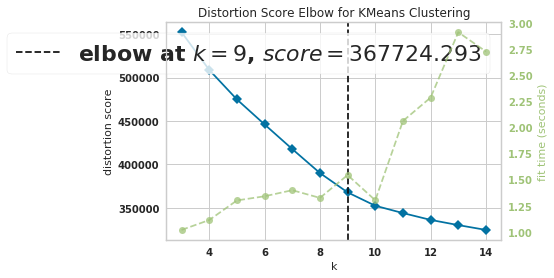

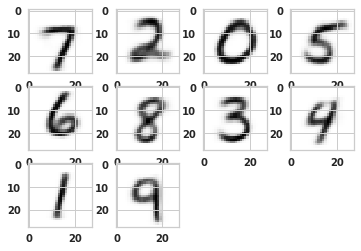

In [91]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


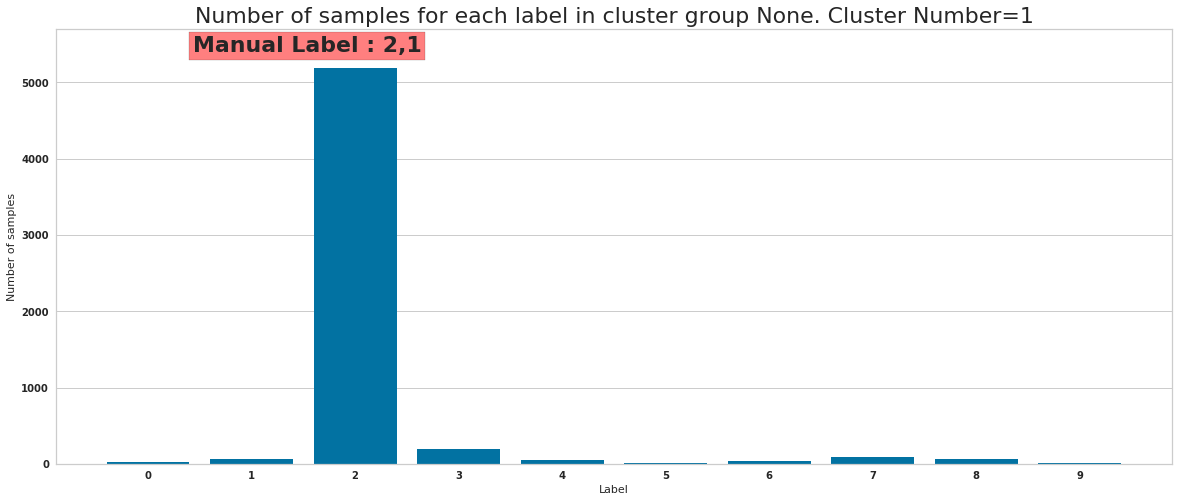

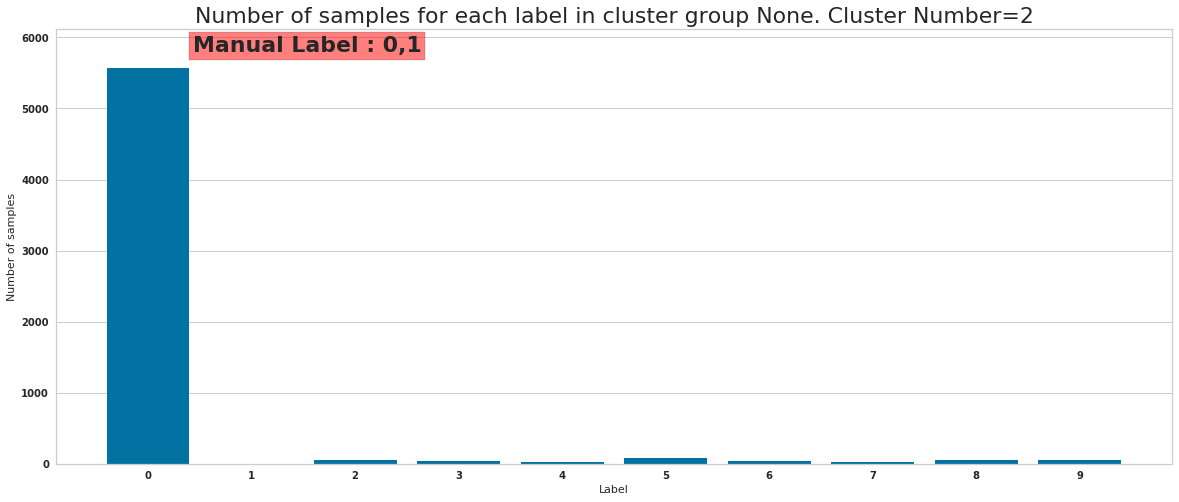

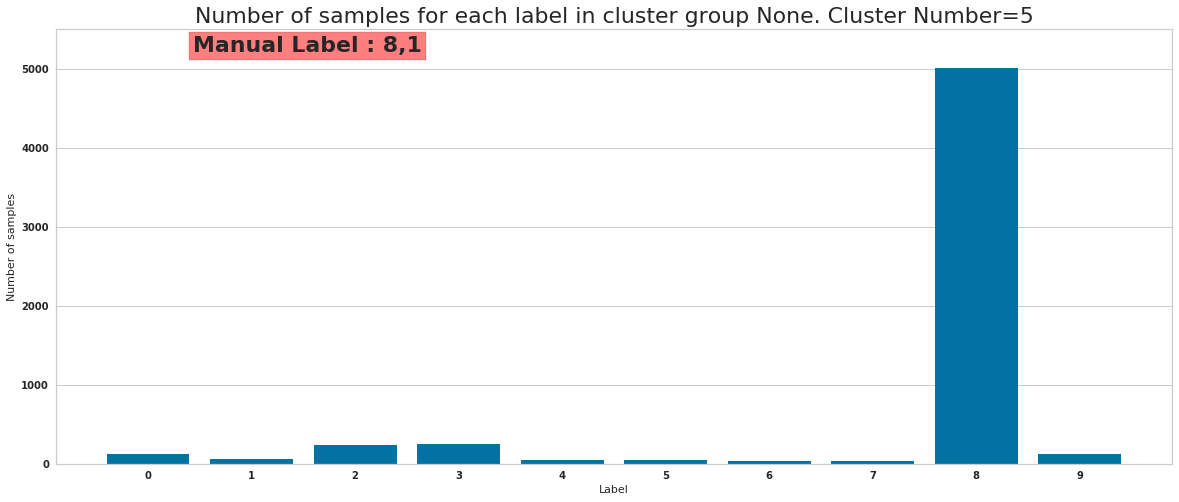

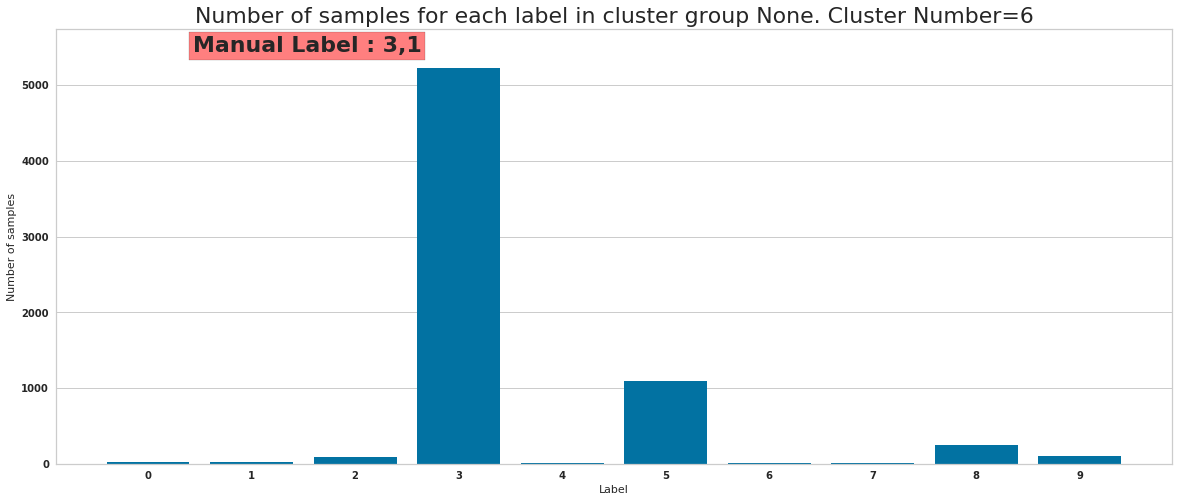

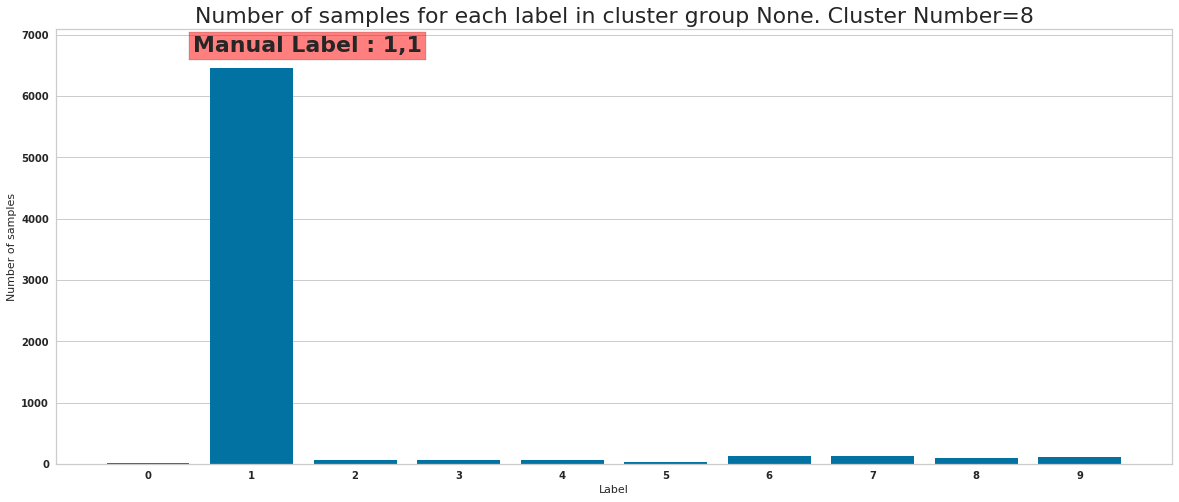

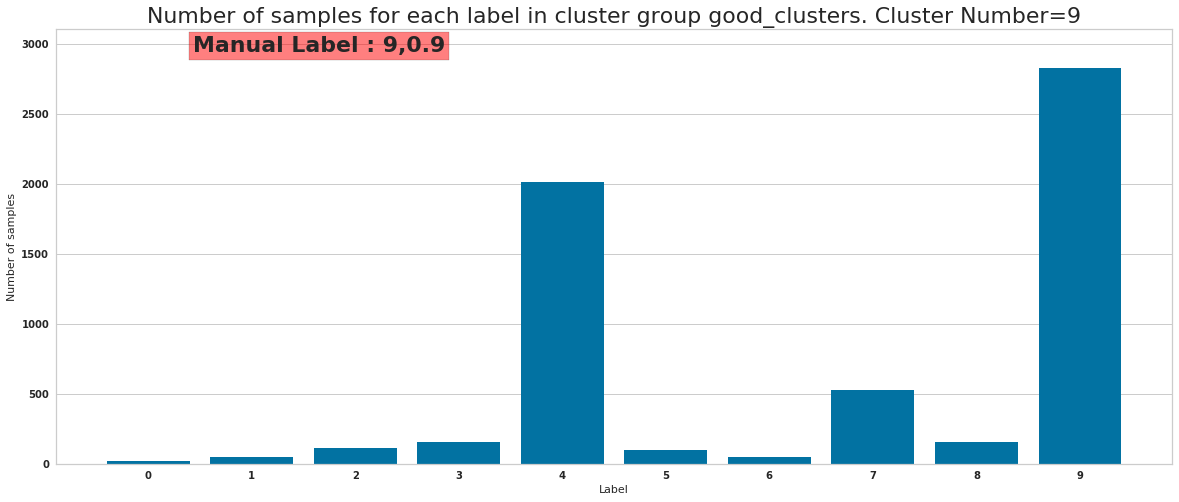

In [92]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 2, 0, 5,
                                           6, 8, 3, 4,
                                           1, 9
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 0.9,
                                               1, 0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [95]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5978, 10)
(5737, 10)
(5941, 10)
(4396, 10)
(5797, 10)
(5978, 10)
(6812, 10)
(6068, 10)
(7141, 10)
(5992, 10)


In [96]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [97]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 7
(5978, 47) (5978, 33)
Num correct=5273
Cluster 0 Manual Label 7 Percentage correct 88.20675811308129
********************************
Manual Label 2
(5737, 47) (5737, 33)
Num correct=5184
Cluster 1 Manual Label 2 Percentage correct 90.36081575736448
********************************
Manual Label 0
(5941, 47) (5941, 33)
Num correct=5563
Cluster 2 Manual Label 0 Percentage correct 93.63743477529036
********************************
Manual Label 5
(4396, 47) (4396, 33)
Num correct=3935
Cluster 3 Manual Label 5 Percentage correct 89.51319381255686
********************************
Manual Label 6
(5797, 47) (5797, 33)
Num correct=5369
Cluster 4 Manual Label 6 Percentage correct 92.61687079523891
********************************
Manual Label 8
(5978, 47) (5978, 33)
Num correct=5005
Cluster 5 Manual Label 8 Percentage correct 83.72365339578454
********************************
Manual Label 3
(6812, 47) (6812, 33)
Num correct=5218
Cluster 6 Manual Label 3 Percentage correct 76.60011

In [98]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

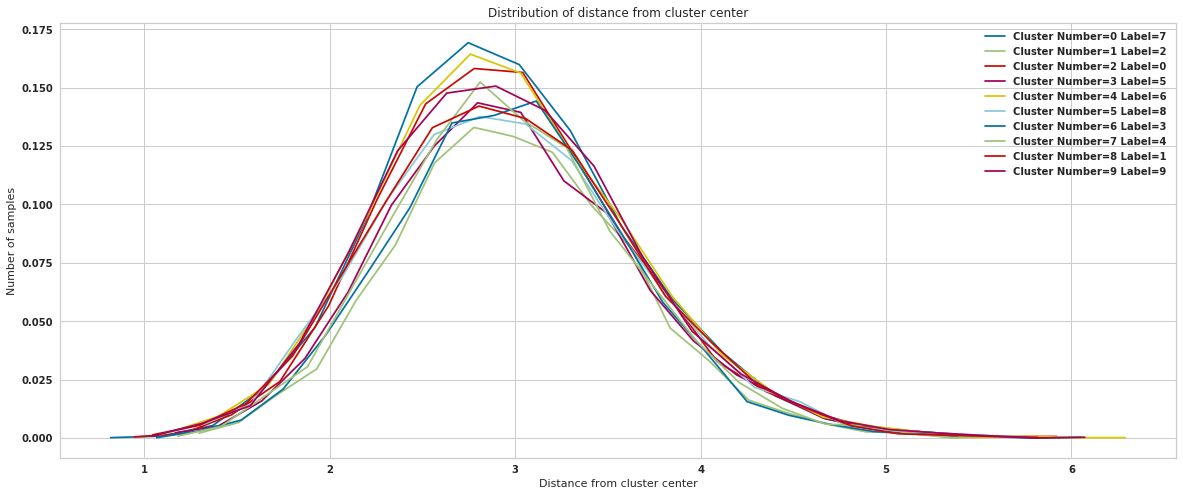

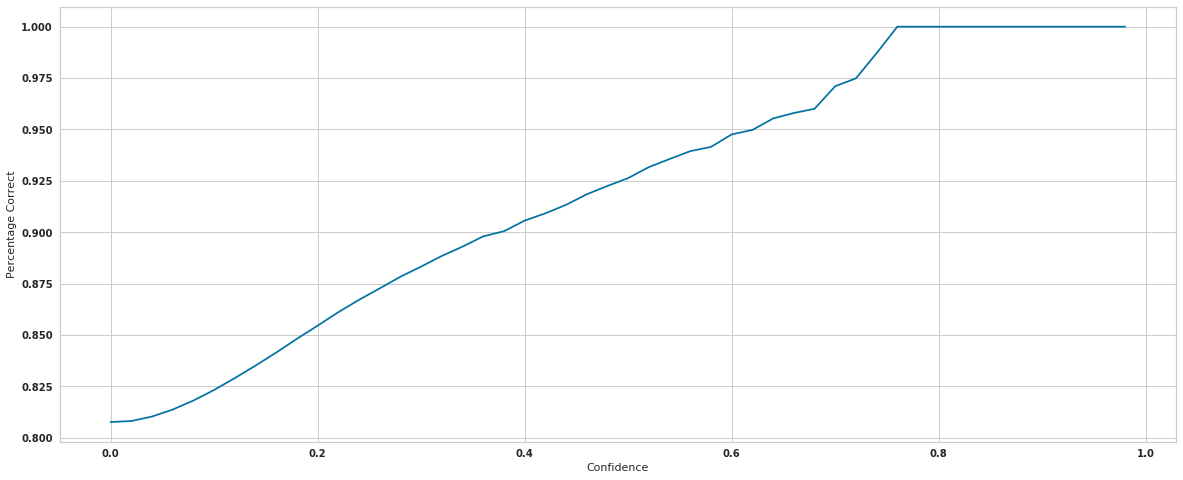

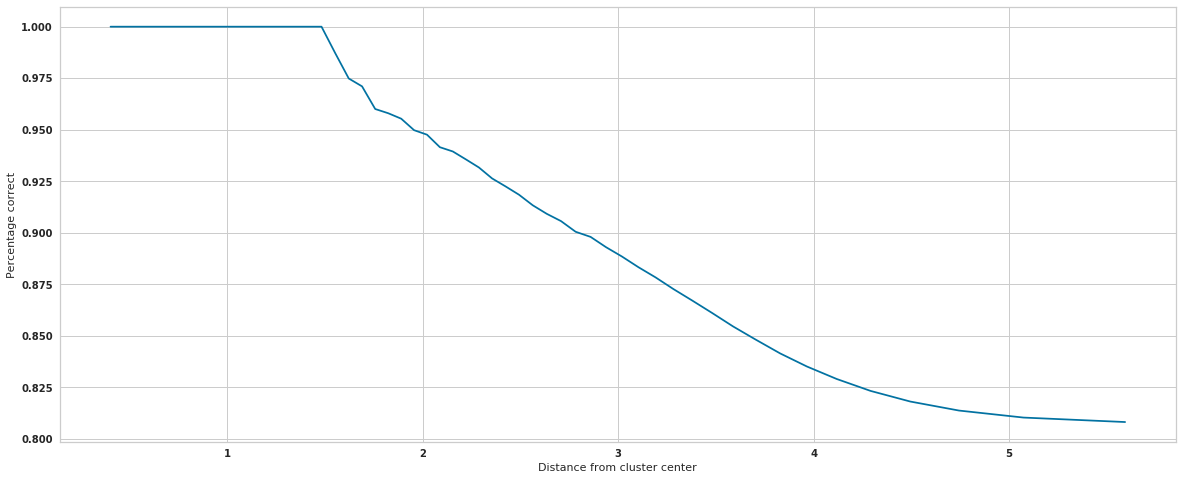

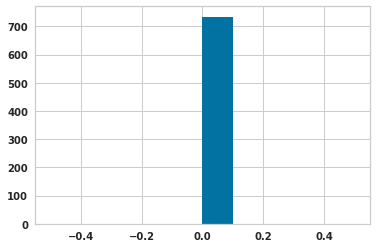

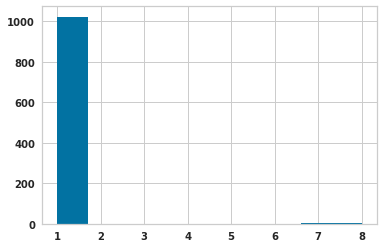

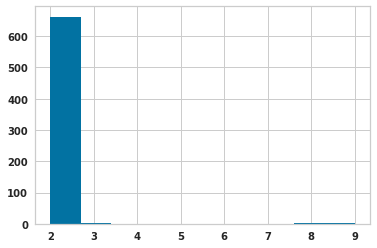

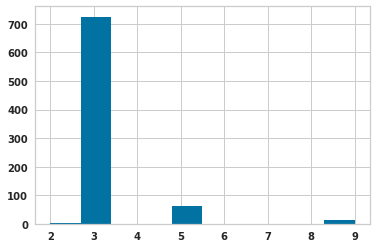

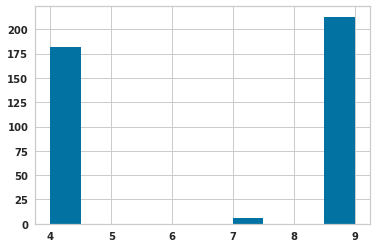

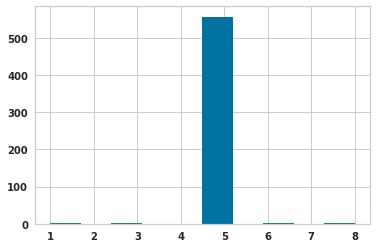

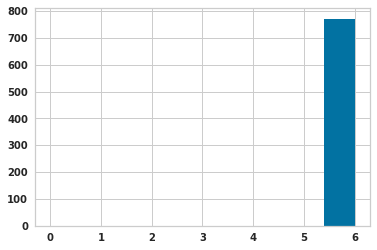

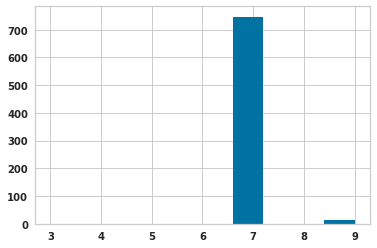

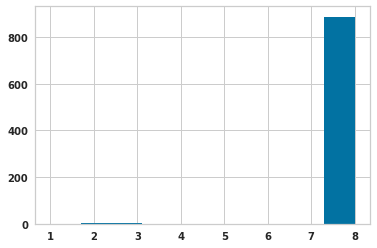

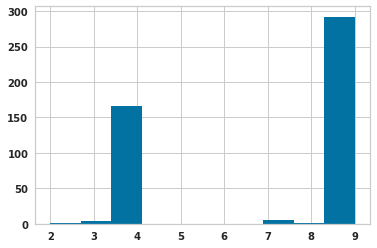

In [99]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()